**7,320 Quantitative Risk Management Assignment:**

Eren Celik (20-608-03)

Mike Nilges (19-606-169)

Oskar Wagner (20-608-303)

# Data exploration

In [1]:
# Load relevant libraries
import pandas as pd

# Load dataset
prices = pd.read_excel("data/Assignment_QRM.xlsx", index_col = 0)

# Transform date column into datetime format
prices["Date"] = pd.to_datetime(prices["Date"])

The dataframe looks as follows:

In [2]:
prices

,Date,NVDA.US,SREN.SW,USDCHF
1,2010-01-04,0.4240,22.7237,1.0292
2,2010-01-05,0.4302,23.1239,1.0336
3,2010-01-06,0.4329,23.5019,1.0278
4,2010-01-07,0.4244,23.2573,1.0338
5,2010-01-08,0.4254,23.5464,1.0237
...,...,...,...,...
3807,2024-10-07,127.7200,110.3000,0.8546
3808,2024-10-08,132.8900,110.4500,0.8568
3809,2024-10-09,132.6500,112.5500,0.8605
3810,2024-10-10,134.8100,115.6500,0.8561


The dataset contains daily prices of `NVDA.US` and `SREN.SW` and the exchange rate `USDCHF` (USD/CHF) starting from January 4th, 2010 until October 11th, 2024.

`SREN.SW` is expressed in CHF. Take USD as common currency for prices.

In [3]:
prices["SREN.SW"] = prices["SREN.SW"]/prices["USDCHF"]

In the following, summary statistics about prices of `NVDA.US` and `SREN.SW`.

In [4]:
prices.describe().iloc[:, 1:3]

,SREN.SW,USDCHF
count,3718.000000,3811.000000
mean,58.364710,0.947644
std,24.923111,0.052303
min,17.723456,0.723200
25%,42.389069,0.912000
50%,56.369441,0.947100
75%,72.001721,0.983800
max,139.797739,1.162900


Check if there is are NA in the dataset:

In [5]:
prices_na = pd.DataFrame(prices.isnull().sum()) # create dataframe of NA's in returns dataset

for asset in range(1,3):
    print("The number of NA's in {} is {}".format(prices_na.index[asset], prices_na.iloc[asset, 0]))

The number of NA's in NVDA.US is 92
The number of NA's in SREN.SW is 93


Substitute NA values with **Last Observation Carried Forward (LOCF)** method, which replaces missing values with the last known value. This method is well suited for data with rising or constant trends (as in this case, see below), but may be source of distortions if trends change direction (GeeksforGeeks, 2023, Section 2).

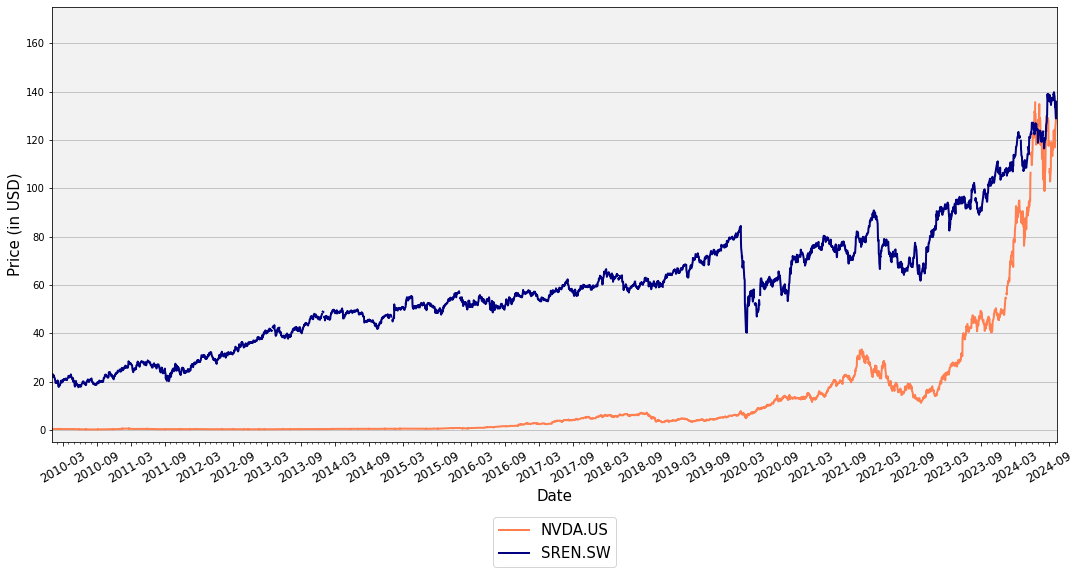

In [6]:
# Import matplotlib for plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Get locators to format x axis
half_year_locator = mdates.MonthLocator(interval = 6)
year_month_formatter = mdates.DateFormatter("%Y-%m")
monthly_locator = mdates.MonthLocator()

# Set figure size and DPI
plt.rcParams["figure.dpi"] = 300

# Set title characteristics
plt.rcParams["axes.titlepad"] = 20
plt.rcParams["axes.titleweight"] = 20

# Set grid parameters
plt.rcParams["grid.color"] = "grey"
plt.rcParams["grid.alpha"] = 0.5

# Define function for the plot of prices
def prices_plots(df):
    """
    Generate plot of prices
    
    Parameters:
    df: dataframe containing prices
    """
    fig, ax = plt.subplots(figsize = (18, 8))
    
    plt.grid(axis = "y")
    
    plt.plot(df["Date"], df["NVDA.US"], color = "#FF7F50", linewidth = 2, label = "NVDA.US")
    plt.plot(df["Date"], df["SREN.SW"], color = "#000080", linewidth = 2, label = "SREN.SW")
    
    ax.set_facecolor("grey")
    ax.patch.set_alpha(0.1)
    
    plt.xlabel("Date", fontsize = 15)
    plt.ylabel("Price (in USD)",fontsize = 15)
    
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    plt.xticks(rotation = 30, fontsize = 12)
    plt.xlim(pd.Timestamp("2010-01-04"), pd.Timestamp("2024-10-11"))
    plt.ylim(-5,175)
    
    plt.legend(loc = "center", bbox_to_anchor = (0.5, -0.23), fontsize = 15, frameon = True)
    
    plt.show()

prices_plots(prices)

Thus, procede in substituting NA's with **LOCF** method:

In [7]:
prices = prices.ffill()

There are some weekdays missing: substitute records of the missing date with the last available record.

In [8]:
# Set "Date" as index of prices
prices = prices.set_index("Date")

# Create a list of all business days (Monday-Friday) from the first observation (to the last observation)
all_dates = pd.date_range(start = prices.index.min(), end = prices.index.max(), freq = "B")

prices = prices.reindex(all_dates) # Substitute new dates inside
prices = prices.ffill() # Fill observations with last available record
prices = prices.reset_index().rename(columns = {"index": "Date"}) # Rename column 'index' to 'Date'

Compute weekly net returns of `NVDA.US` and `SREN.SW`. We compute returns from Friday to Friday.

In [9]:
# Function that takes data set and column name as input and returns net return of its values
def compute_return(df, colname): 
    """
    Computes the net return of the column containing prices
    
    Parameters:
    df: dataframe containing prices
    colname: name of the column for which the net returns are computed
    """
    df[colname + "-R"] = (df[colname]/df[colname].shift(1))-1 # create "variable-R" column and insert return
    df = df.reset_index(drop = True) # drop old index
    df.index += 1 # start index from 1
    return df

# Create empty data frame which will contain friday pices of NVDA.US and SREN.SW
returns = pd.DataFrame(columns = ["Date", "NVDA.US", "SREN.SW"])

row_weekly = 0

# Append all prices in Friday of NVDA.US and SREN.SW to the "returns" dataframe
for date in prices["Date"]:
    if date.dayofweek == 4: # Check if date is Friday (= 4)
        row_daily = prices[prices["Date"] == date].index[0] # Get nr. row in prices dataframe with Friday as date
        returns.loc[row_weekly] = [date, prices["NVDA.US"][row_daily], prices["SREN.SW"][row_daily]] # Insert record in returns dataframe
        row_weekly += 1

# Compute weekly net returns of NVDA.US and SREN.SW
returns = compute_return(returns, "NVDA.US")
returns = compute_return(returns, "SREN.SW")

# Drop first row
returns = returns.dropna()
returns = returns.reset_index(drop = True)
returns.index += 1

returns

,Date,NVDA.US,SREN.SW,NVDA.US-R,SREN.SW-R
1,2010-01-15,0.3923,21.729250,-0.077809,-0.055302
2,2010-01-22,0.3774,19.459485,-0.037981,-0.104457
3,2010-01-29,0.3529,19.497172,-0.064918,0.001937
4,2010-02-05,0.3719,18.485919,0.053840,-0.051867
5,2010-02-12,0.3978,18.236612,0.069642,-0.013486
...,...,...,...,...,...
766,2024-09-13,119.1000,136.470727,0.158321,0.004959
767,2024-09-20,116.0000,136.807434,-0.026029,0.002467
768,2024-09-27,121.4000,139.797739,0.046552,0.021858
769,2024-10-04,124.9200,133.857809,0.028995,-0.042489


In [10]:
returns.describe().iloc[:, 3:5]

,SREN.SW-R
count,770.000000
mean,0.002976
std,0.036524
min,-0.238188
25%,-0.013496
50%,0.003024
75%,0.020315
max,0.290207


How did the returns change over time?

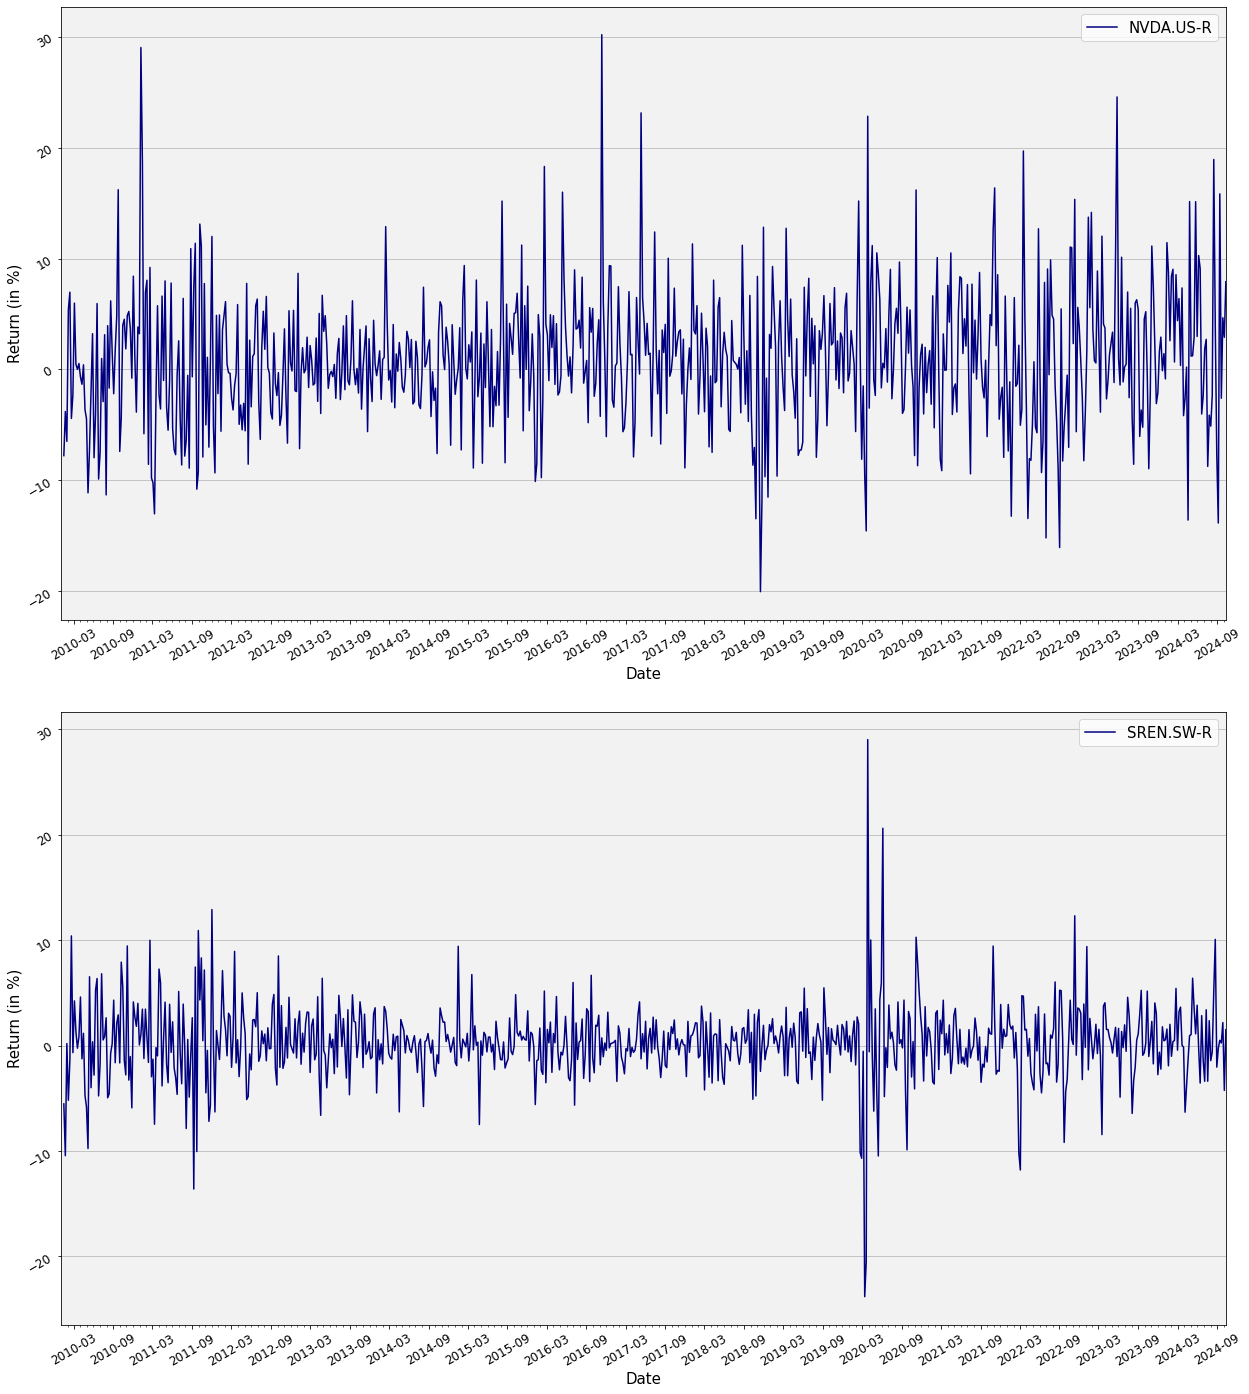

In [11]:
fig, axs = plt.subplots(2, figsize = (18, 20))

# Set up common properties for both axes
for ax in axs:
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    ax.set_facecolor("grey")
    ax.patch.set_alpha(0.1)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Return (in %)", fontsize=15)
    ax.tick_params(labelrotation=30, labelsize=12)
    ax.grid(axis = "y")
    ax.set_xlim(pd.Timestamp("2010-01-04"), pd.Timestamp("2024-10-11"))

# Plot data
axs[0].plot(returns["Date"], returns["NVDA.US-R"]*100, color = "#000080", label = "NVDA.US-R")
axs[1].plot(returns["Date"], returns["SREN.SW-R"]*100, color = "#000080", label = "SREN.SW-R")


axs[0].legend(fontsize = 15)
axs[1].legend(fontsize = 15)

fig.tight_layout(pad = 3)

plt.show()

What about the distribution of the returns?

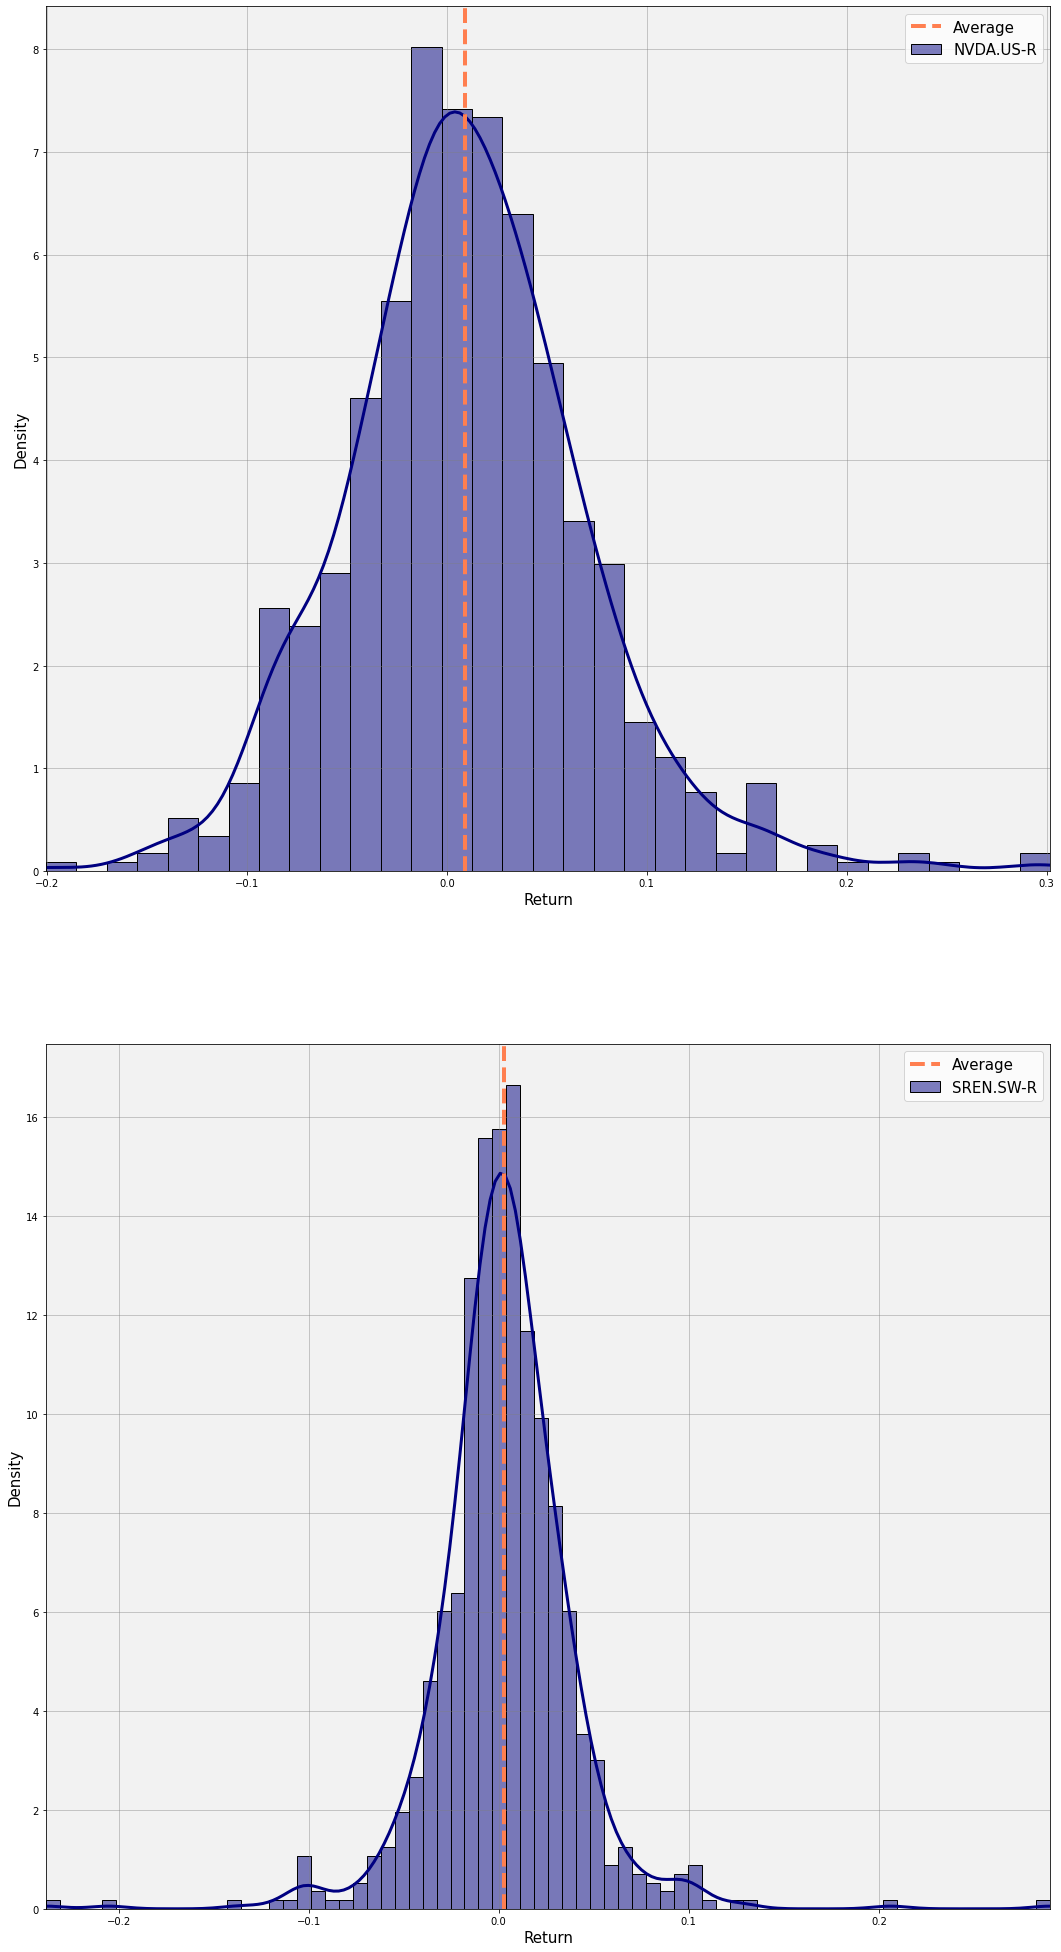

In [12]:
# Import seaborn for histograms
import seaborn as sns

nvda = returns["NVDA.US-R"].to_numpy()
sren = returns["SREN.SW-R"].to_numpy()


# Get minimum, maximum, and average of both NVDA.US and SREN.SW
nvda_min = nvda.min(); sren_min = sren.min()
nvda_max = nvda.max(); sren_max = sren.max()
nvda_avg = nvda.mean(); sren_avg = sren.mean()

fig, axs = plt.subplots(2, figsize = (18, 35))

# Set common properties for the figures
for ax in axs:
    ax.set_facecolor("grey")
    ax.patch.set_alpha(0.1)
    ax.set_xlabel("Return", fontsize = 15)
    ax.set_ylabel("Density", fontsize = 15)
    ax.grid()

# Plot distribution of the net returns
sns.histplot(nvda, ax = axs[0],
             kde = True, stat = "density",
             color = "#000080", line_kws={"linewidth": 3}, label = "NVDA.US-R")

sns.histplot(sren, ax = axs[1],
             kde = True, stat = "density",
             color = "#000080", line_kws={"linewidth": 3}, label = "SREN.SW-R")

# Improve plot
axs[0].set_xlim(nvda_min, nvda_max)
axs[0].axvline(x = nvda_avg, color = "#FF7F50", linestyle = "--", linewidth = 4, label = "Average")

axs[1].set_xlim(sren_min, sren_max)
axs[1].axvline(x = sren_avg, color = "#FF7F50", linestyle = "--", linewidth = 4, label = "Average")

axs[0].legend(fontsize = 15)
axs[1].legend(fontsize = 15)

plt.show()

As one can see, all distributions have long tails and appear to be slightly right skewed. Now compare the KDE of each distribution to a normal distribution with same mean and variance.

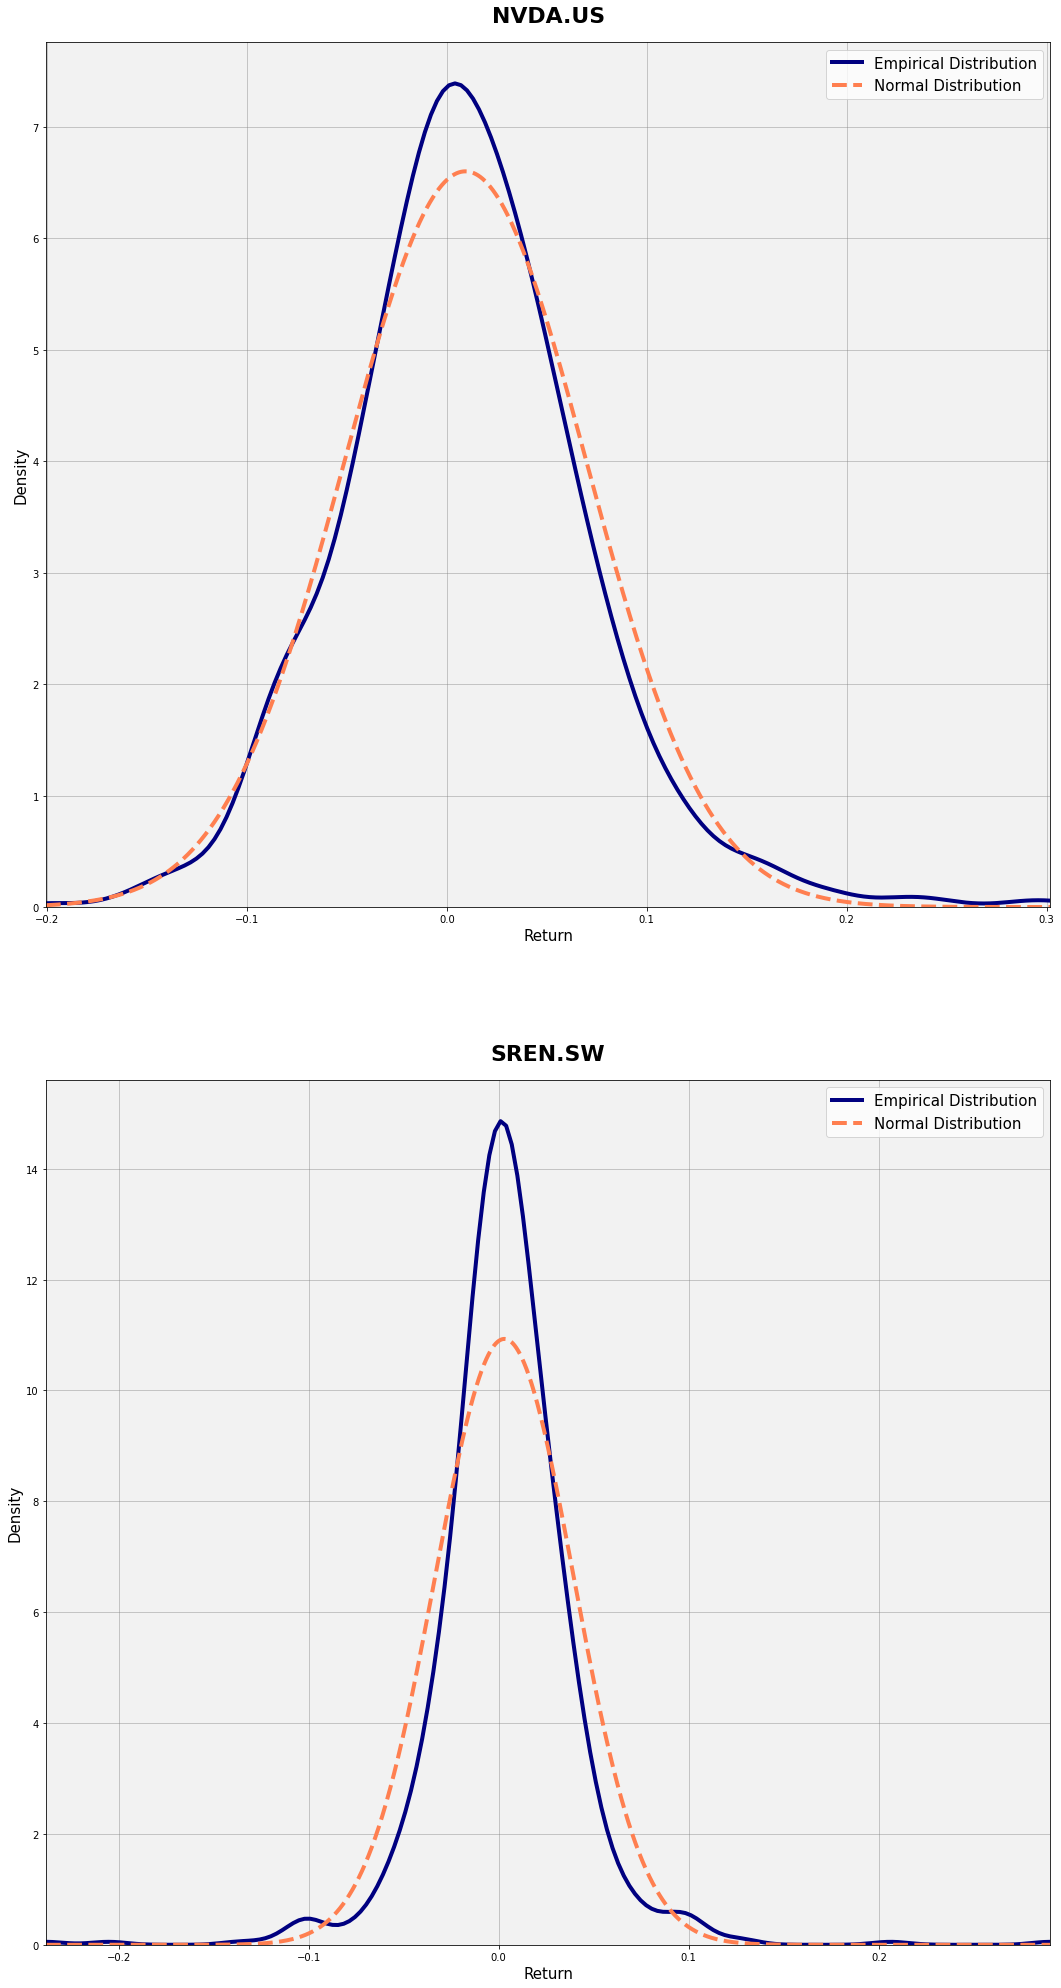

In [13]:
# Import numpy
import numpy as np

# Import scipy.stats.norm to generate normally distributed observations
from scipy.stats import norm

# Generate normally distributed returns with same mean and standard deviation as NVDA.US, SREN.SW
nvda_std = nvda.std(); sren_std = sren.std()

nnvda_x = np.linspace(nvda_min, nvda_max, 10000)  # Create a range of x-values for nvda to make it quasi continuous
nvda_norm = norm.pdf(nnvda_x, nvda_avg, nvda_std)  # PDF of normal distribution

nsren_x = np.linspace(sren_min, sren_max, 10000)  # Create a range of x-values for sren to make it quasi continuous
sren_norm = norm.pdf(nsren_x, sren_avg, sren_std)  # PDF of normal distribution

fig, axs = plt.subplots(2, figsize = (18, 35))

# Set common properties for the figures
for ax in axs:
    ax.set_facecolor("grey")
    ax.patch.set_alpha(0.1)
    ax.set_xlabel("Return", fontsize=15)
    ax.set_ylabel("Density", fontsize=15)
    ax.grid()

# Plot kernel density estimation for NVDA.US and SREN.SW
sns.kdeplot(nvda, ax = axs[0],
            color = "#000080", linewidth = 4,
            label = "Empirical Distribution")

sns.kdeplot(sren, ax = axs[1],
            color = "#000080", linewidth = 4,
            label = "Empirical Distribution")

# Plot the normal distributions
axs[0].plot(nnvda_x, nvda_norm, linestyle = "dashed", color = "#FF7F50", linewidth = 4, label = "Normal Distribution")
axs[1].plot(nsren_x, sren_norm, linestyle = "dashed", color = "#FF7F50", linewidth = 4, label = "Normal Distribution")

# Improve plot
axs[0].set_title("NVDA.US", fontsize = 22, fontweight = 'bold')
axs[1].set_title("SREN.SW", fontsize = 22, fontweight = 'bold')

axs[0].set_xlim(nvda_min, nvda_max)
axs[1].set_xlim(sren_min, sren_max)

axs[0].legend(fontsize = 15)
axs[1].legend(fontsize = 15)

plt.show()

It is clear that these returns are not normally distributed because of the fat tails. This is also confirmed via the Shapiro Wilk test for normality:

In [14]:
from scipy.stats import shapiro
print("The p-value of the Shapiro Wilk test for NVDA.US-R is {}".format(shapiro(nvda)[1]))
print("The p-value of the Shapiro Wilk test for SREN.SW-R is {}".format(shapiro(sren)[1]))

The p-value of the Shapiro Wilk test for NVDA.US-R is 3.066724652001085e-09
The p-value of the Shapiro Wilk test for SREN.SW-R is 4.761696700110615e-22


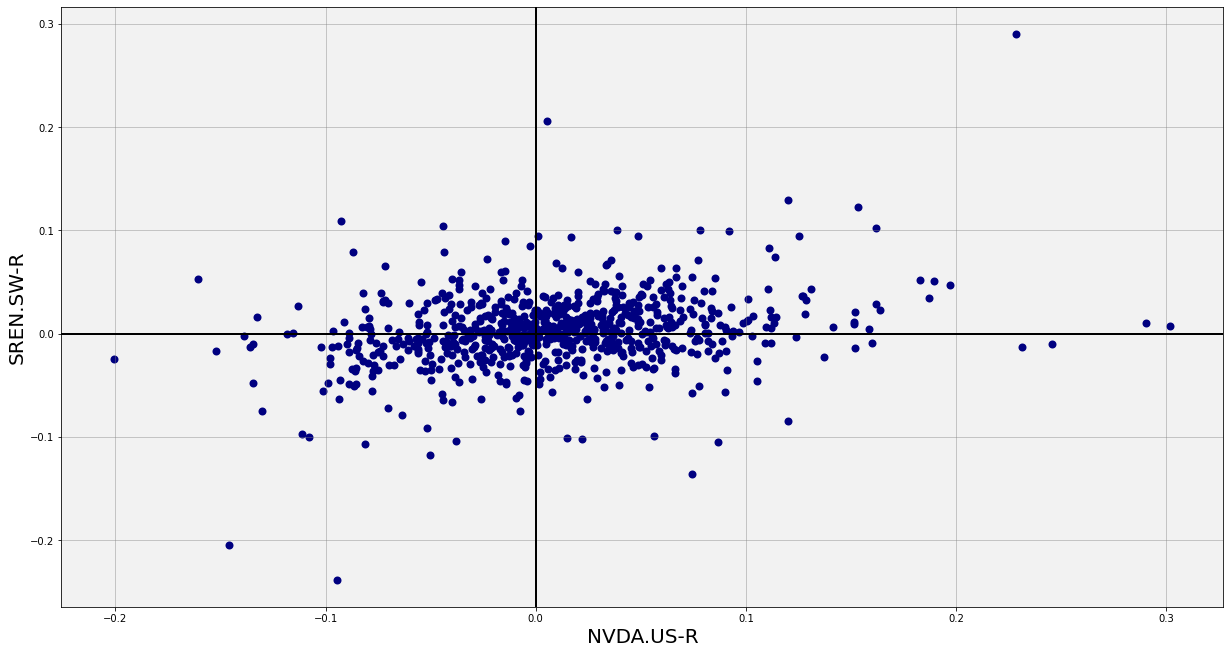

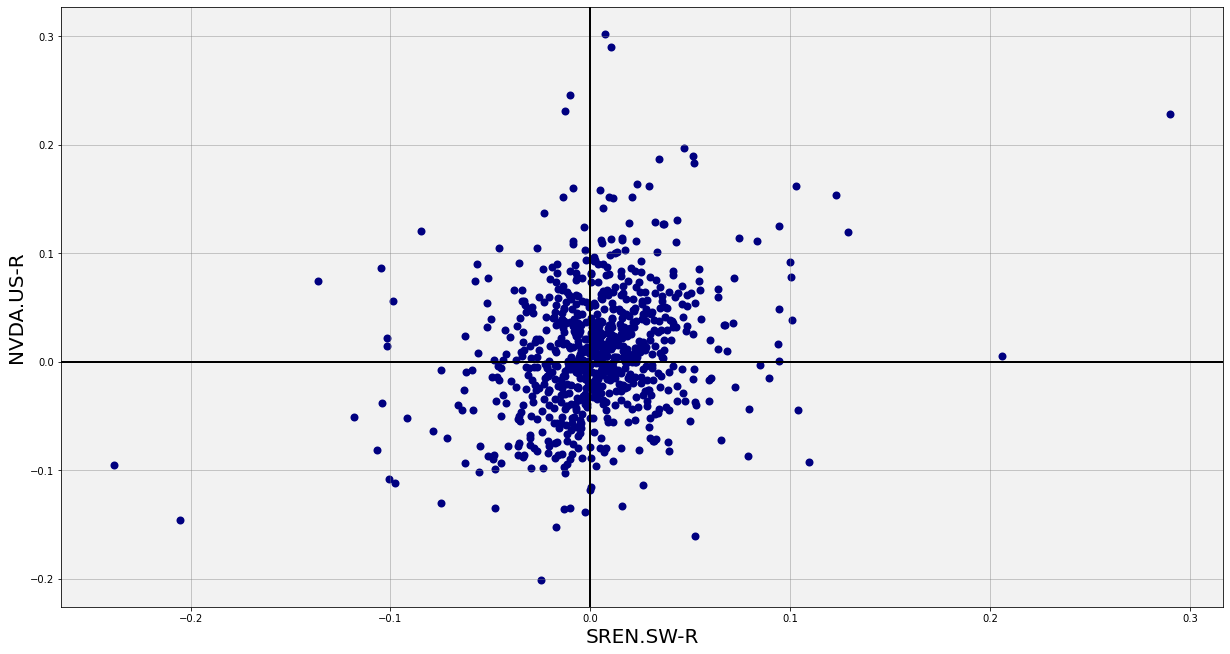

In [15]:
# Define function that plots net returns of NVDA.US and SREN.SW
def return_plot_against(df, col1, col2):
    """
    Plot column 1 against column 2
    
    Parameters:
    df: dataframe containing prices
    col1: first price column
    col2: second price column
    """
    fig, ax = plt.subplots(figsize = (18, 10))
    
    ax.set_facecolor("grey")
    ax.patch.set_alpha(0.1)
    ax.grid()
    
    plt.scatter(df[col1], df[col2], color = "#000080", linewidth = 2, label = "NVDA")

    ax.axhline(y = 0, linewidth = 2, color = 'black')
    ax.axvline(x = 0, linewidth = 2, color = 'black')
    
    plt.xlabel(col1, fontsize = 20)
    plt.ylabel(col2,fontsize = 20)
    
    plt.tight_layout(pad = 4)
    plt.show()

# Plot net returns of NVDA.US and SREN.SW against each other
return_plot_against(returns, "NVDA.US-R", "SREN.SW-R")
return_plot_against(returns, "SREN.SW-R", "NVDA.US-R")

# Assignment

According to the exercise, the investor invests a total of $\lambda_1 = 30\%$ and $\lambda_2 = 70\%$, where $i = 1, 2$ stands for `SREN.SW` and `NVDA.US`, respectively. Her wealth is equal to the amount

$$
W_0 = $10,000,000
$$
The portfolio's profit and loss distribution follows:

$$
\mathbf{L} = \mathbf{W} - W_0 = W_0[\lambda_1 \cdot \mathbf{R}_1 + \lambda_2 \cdot \mathbf{R}_2]
$$

Where $\mathbf{R}_1$ and $\mathbf{R}_2$ are weekly returns of Swiss Re and Nvidia, respectively.

# Exercise (i)

## M1

To create the M1 matrix, we simply take the existing empirical observations.

In [16]:
import numpy as np

# R_M1 contains weekly net returns of SREN.SW and NVDA.US
R_M1 = np.stack((sren, nvda), axis = 1)
R1_M1 = sren
R2_M1 = nvda

## M2

In M2, we assume that our original $\mathbf{R}$ vector is bivariate Gaussian distributed with mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$. The formulas for the MLE estimates are provided in the paper.

In [17]:
# Estimate the mu vector for R1 and R2
def estimate_mu_Sigma(R1_M1_f, R2_M1_f):
    """
    Returns the estimated mean vector, covariance matrix, standard errors of R1 and R2, and the estimated correlation
    between R1 and R2
    
    Parameters:
    R1_M1_f: empirical return of SREN.SW
    R2_M1_f: empirical return of NVDA.US
    """
    # Number of observations 
    N = len(R1_M1_f)
    
    # Estimate mean of R1 and R2
    muR1_hat_f = (1/N)*np.sum(R1_M1_f)
    muR2_hat_f = (1/N)*np.sum(R2_M1_f)
    
    # Generate single return matrix
    R_M1_f = np.stack((R1_M1_f, R2_M1_f), axis = 1)

    # Put both means into a mu_hat_f vector
    mu_hat_f = np.stack((muR1_hat_f, muR2_hat_f))

    # Compute X_i - mu^hat (i.e., center each net return around its mean)
    centered_data = R_M1_f - mu_hat_f

    # Estimate the covariance matrix
    sigma_hat_f = (1/(N-1))*(centered_data.transpose()@centered_data)

    # Get individual standard deviation (std) estimates for SREN.US (R1), NVDA.US (R2), and rho hat (correlation)
    stdR1_hat_f = np.sqrt(sigma_hat_f[0,0])
    stdR2_hat_f = np.sqrt(sigma_hat_f[1,1])
    corr_hat_f = sigma_hat_f[0,1]/(stdR1_hat_f*stdR2_hat_f)
    
    return mu_hat_f, sigma_hat_f, stdR1_hat_f, stdR2_hat_f, corr_hat_f

mu_hat, sigma_hat, stdR1_hat, stdR2_hat, corr_hat = estimate_mu_Sigma(R1_M1, R2_M1)
muR1_hat = mu_hat[0]
muR2_hat = mu_hat[1]

print("MLE estimation yields the following results:")
print("- Estimate mean of SREN.SW-R: {}".format(round(muR1_hat, 5)))
print("- Estimate standard deviation of SREN.SW-R: {}".format(round(stdR1_hat, 4)))
print("- Estimate mean of NVDA.US-R: {}".format(round(muR2_hat, 5)))
print("- Estimate standard deviation of NVDA.US-R: {}".format(round(stdR2_hat, 4)))
print("- Estimate correlation between NVDA.US-R and SREN.SW-R: {}".format(round(corr_hat, 3)))

MLE estimation yields the following results:
- Estimate mean of SREN.SW-R: 0.00298
- Estimate standard deviation of SREN.SW-R: 0.0365
- Estimate mean of NVDA.US-R: 0.00929
- Estimate standard deviation of NVDA.US-R: 0.0605
- Estimate correlation between NVDA.US-R and SREN.SW-R: 0.271


## M3

In M3, we assume that each empirical return is Gaussian distributed with mean $\mu_i$ and standard deviation $\sigma_i$ for $i=1,2$. After standardizing these returns with $\mu_i$ and $\sigma_i$, i.e. with the estimated parameters $\hat{\mu_i}$ and $\hat{\sigma_i}$, we take the cumulative of the Gaussian distribution to make each return uniform distributed. Then, we fit a Gumbel copula and estimate the parameter $\theta$.

In [18]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

R1_M3 = np.array(returns["SREN.SW-R"])
R2_M3 = np.array(returns["NVDA.US-R"])

# Transform to uniform (0, 1) using Gaussian CDF
epsilon = 1e-10
R1_M3_uniform = np.clip(norm.cdf((R1_M3 - muR1_hat) / stdR1_hat), epsilon, 1 - epsilon)
R2_M3_uniform = np.clip(norm.cdf((R2_M3 - muR2_hat) / stdR2_hat), epsilon, 1 - epsilon)

def gumbel_copula_log_likelihood(theta, u1, u2):
    """
    Returns the log-likelihood of the Gumbel copula
    
    Parameters:
    theta: parameter modelling upper-tail dependence of u1 and u2
    u1: uniform R1
    u2: uniform R1
    """
    if theta < 1:
        return np.inf  # Gumbel copula parameter must be >= 1

    # Calculate terms for the Gumbel copula
    log_u1 = -np.log(u1)
    log_u2 = -np.log(u2)
    term1 = log_u1 ** theta
    term2 = log_u2 ** theta
    sum_terms = term1 + term2
    A = sum_terms ** (1 / theta)
    C = np.exp(-A)

    # Calculate the copula's joint density
    density = (C * (log_u1 * log_u2) ** (theta - 1) *
               (A + theta - 1) /
               (u1 * u2 * sum_terms ** (2 - 1 / theta)))

    # Log-likelihood: sum of log of the joint density
    log_likelihood = np.sum(np.log(density))
    
    return -log_likelihood  # Negative for minimization

# Estimate theta using MLE by minimizing the negative log-likelihood
theta_initial = 5  # Starting guess for theta
result = minimize(gumbel_copula_log_likelihood, theta_initial, args = (R1_M3_uniform, R2_M3_uniform), bounds = [(1, None)])
theta_est = result.x[0]
print(f"Estimated Gumbel copula parameter: {theta_est}")

Estimated Gumbel copula parameter: 1.1330987140250817


We can confirm this finding visually:

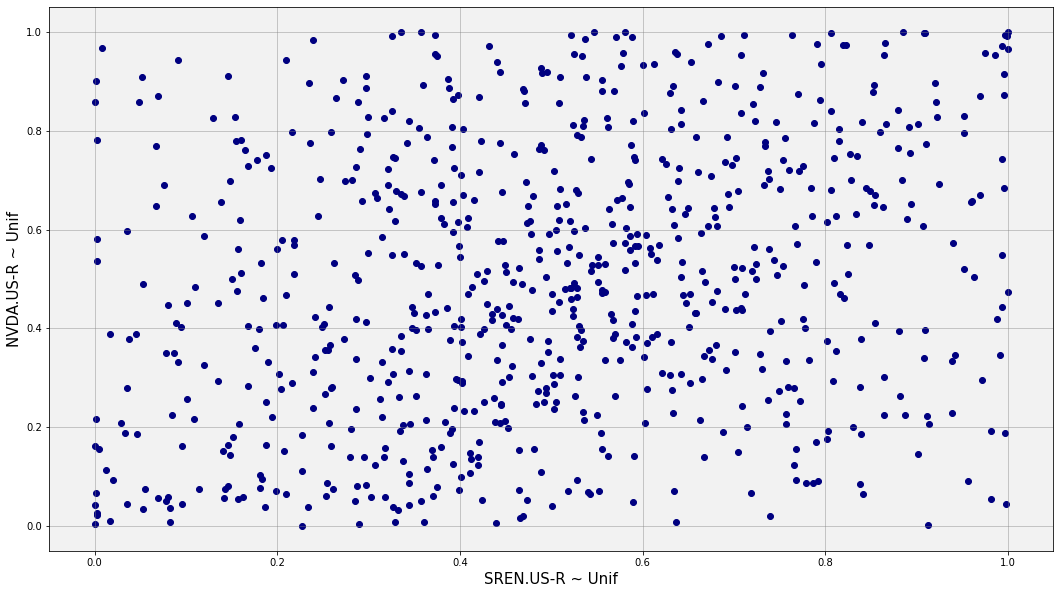

In [19]:
fig, ax = plt.subplots(figsize = (18, 10))

ax.set_facecolor("grey")
ax.patch.set_alpha(0.1)

ax.set_xlabel("SREN.US-R ~ Unif", fontsize=15)
ax.set_ylabel("NVDA.US-R ~ Unif", fontsize=15)

ax.grid()

plt.scatter(R1_M3_uniform, R2_M3_uniform, color = "#000080")

plt.show()

## M4

For M4, we apply a two step optimization process, as outlined in the paper.

In [20]:
from scipy.stats import t
from scipy.special import gamma
from scipy.optimize import minimize
import numpy as np

def marginal_t_log_likelihood(nu, R, mu, sigma):
    """
    Returns the log-likelihood for the marginal Student's t distribution
    
    Parameters:
    nu: degrees of freedom
    R: vector containing returns
    mu: estimated mean
    sigma: estimated sigma
    """
    epsilon = (R - mu) / sigma  # Standardized residuals
    
    t_density = gamma((nu + 1) / 2) / (np.sqrt(nu * np.pi) * gamma(nu / 2)) * \
                (1 + epsilon**2 / nu)**(-(nu + 1) / 2)
    
    log_t_density = np.log(np.maximum(t_density, 1e-12))  # Avoid log(0)
    
    return -np.sum(log_t_density)  # Negative for minimization

def gaussian_copula_log_likelihood(rho, u1, u2):
    """
    Returns the log-likelihood for the Gaussian copula
    
    Parameters:
    rho: correlation
    u1: uniform R1
    u2: uniform R2
    """
    z1 = norm.ppf(u1)  # Transform to Gaussian marginals
    z2 = norm.ppf(u2)
    
    copula_density = -0.5 * (np.log(1 - rho ** 2) + (z1 ** 2 + z2 ** 2 - 2 * rho * z1 * z2) / (1 - rho ** 2))
    
    return -np.sum(copula_density)  # Negative for minimization

def estimate_nu_rhothilde(R1_M1_f, R2_M1_f):
    """
    Estimates nu and rho thilde, taking estimations of M2 as given
    
    R1_M1_f: empirical return of asset 1 (SREN.SW)
    R2_M1_f: empirical return of asset 2 (NVDA.US)
    """
    # Estimate parameters from M2
    mu_hat_f, sigma_hat_f, stdR1_hat_f, stdR2_hat_f, corr_hat_f = estimate_mu_Sigma(R1_M1_f, R2_M1_f)
    muR1_hat_f = mu_hat_f[0]
    muR2_hat_f = mu_hat_f[1]
    
    # Estimate nu1
    nu1_result = minimize(marginal_t_log_likelihood, [10],  args = (R1_M1_f, muR1_hat_f, stdR1_hat_f),  bounds=[(2, 50)])
    nu1_hat_f = nu1_result.x[0]

    # Estimate nu2
    nu2_result = minimize(marginal_t_log_likelihood, [10], args = (R2_M1_f, muR2_hat_f, stdR2_hat_f), bounds=[(2, 50)])
    nu2_hat_f = nu2_result.x[0]

    # Standardize residuals using fixed mu and sigma
    epsilon1 = (R1_M1_f - muR1_hat) / stdR1_hat_f
    epsilon2 = (R2_M1_f - muR2_hat) / stdR2_hat_f

    # Transform to uniform margins using the t-CDF with estimated degrees of freedom
    u1 = t.cdf(epsilon1, df = nu1_hat_f)
    u2 = t.cdf(epsilon2, df = nu2_hat_f)
    
    # Estimate rho
    rho_result = minimize(gaussian_copula_log_likelihood, [0.5], args = (u1, u2), bounds = [(-0.99, 0.99)])
    rho_hat_f = rho_result.x[0]
        
    return nu1_hat_f, nu2_hat_f, rho_hat_f

In [21]:
nu1_hat, nu2_hat, rho_hat = estimate_nu_rhothilde(R1_M1, R2_M1)
print("Estimated degrees of freedom:\nnu1 = {}, nu2 = {}".format(nu1_hat, nu2_hat))
print("Estimated copula correlation:\nrho = {}".format(rho_hat))

Estimated degrees of freedom:
nu1 = 8.514562871526133, nu2 = 15.19599924344702
Estimated copula correlation:
rho = 0.3426010976787736


We generate returns in the following way:

In [22]:
import numpy as np
from scipy.stats import chi2, multivariate_normal

def generate_returns(R1_M1_f, R2_M1_f, sim_f = 10000):
    """
    Generate returns for M4
    
    R1_M1_f: empirical return of asset 1 (SREN.SW)
    R2_M1_f: empirical return of asset 2 (NVDA.US)
    sim_f: number of simulations
    """
    # Set random number generator
    rng = np.random.default_rng(seed = 4)
    
    # Estimate Parameters
    mu_hat_f, sigma_hat_f, stdR1_hat_f, stdR2_hat_f, corr_hat_f = estimate_mu_Sigma(R1_M1_f, R2_M1_f)
    nu1_hat_f, nu2_hat_f, rho_hat_f = estimate_nu_rhothilde(R1_M1_f, R2_M1_f)


    # Covariance matrix for Gaussian copula
    Sigma = [[1, rho_hat_f], [rho_hat_f, 1]]

    # Step 1: Simulate Z ~ N(0, Sigma)
    Z = rng.multivariate_normal(mean = [0, 0], cov = Sigma, size = sim_f)

    # Step 2: Simulate Y1 and Y2 ~ Chi-squared(nu)
    Y1 = rng.chisquare(df = nu1_hat_f, size = sim_f)
    Y2 = rng.chisquare(df = nu2_hat_f, size = sim_f)

    # Step 3: Scale Z to obtain Epsilon1 and Epsilon2
    eps1 = np.sqrt(nu1_hat_f / Y1) * Z[:, 0]
    eps2 = np.sqrt(nu2_hat_f / Y2) * Z[:, 1]

    # Step 4: Construct returns
    R1_M4_f = mu_hat_f[0] + stdR1_hat_f * eps1
    R2_M4_f = mu_hat_f[1] + stdR2_hat_f * eps2
    
    return R1_M4_f, R2_M4_f

This correlation can be visually confirmed:

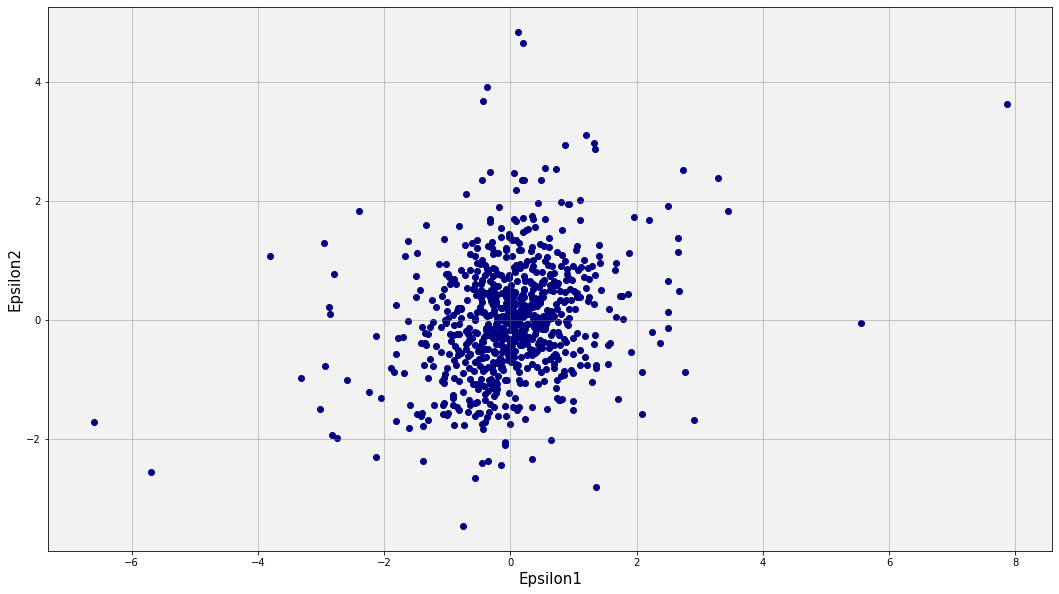

In [23]:
# Define epsilon
epsilon1 = (R1_M1 - muR1_hat)/stdR1_hat
epsilon2 = (R2_M1 - muR2_hat)/stdR2_hat

fig, ax = plt.subplots(figsize = (18, 10))

ax.set_facecolor("grey")
ax.patch.set_alpha(0.1)
ax.grid()
ax.set_xlabel("Epsilon1", fontsize=15)
ax.set_ylabel("Epsilon2", fontsize=15)

plt.scatter(epsilon1, epsilon2, color = "#000080")

plt.show()

# Exercise (ii)

Using M1 for $\mathbf{R}$, we simulate the portfolio's profit and loss distribution by picking $10,000$ returns in $\mathbf{R}$ with replacement.

In [24]:
def p_return(R1_f, R2_f, lambda1_f, lambda2_f):
    """
    Computes portfolio return
    
    Parameters:
    R1_f: returns of SREN.SW (asset 1)
    R2_f: returns of NVDA.US (asset 2)
    lambda1_f: portfolio weight of SREN.SW
    lambda2_f: portfolio weight of NVDA.US
    """
    p_return_f = lambda1_f*R1_f + lambda2_f*R2_f
    return p_return_f

def compute_VaR_ES(df, conf_lvls):
    """
    Computes Value-at-Risk (VaR) and Expected Shortfall (ES)
    
    Parameters:
    df: numpy array containing portfolio's profit and losses
    conf_lvls: list of confidence levels to compute VaR and ES
    """
    # Define lists containing VaR and ES estimations for different confidence levels
    VaR_historical_f = []
    ES_historical_f = []
    
    df = sorted(df) # sort the values in df in ascending order
    
    for alpha in conf_lvls: # compute VaR and ES for each alpha
        var_index = int(np.floor(round(len(df)*(1-alpha))) - 1) # find VaR index
        tail_losses = df[:var_index + 1] # Find all values lower than VaR
        es = np.mean(tail_losses) # Compute the conditional expectation
        VaR_historical_f.append(df[var_index])
        ES_historical_f.append(es)
        
    return VaR_historical_f, ES_historical_f

from matplotlib.ticker import FuncFormatter

def thousands(x, pos):
    """
    Formats x axis and shows values in thousands
    """
    return f'${int(x):,}'

def milions(x, pos):
    """
    Formats x axis and shows values in milions
    """
    return f'${int(x*1e-6)}M'

def plot_VaR_ES(simulated_df, conf_lvls, VaR_historical_f, ES_historical_f, x_axis_formatter):
    """
    Plots the VaR and ES.
    
    Parameters:
    simulated_df: array of portfolio's profit and loss 
    conf_lvls: list of confidence levels to compute VaR and ES
    VaR_historical_f: list of VaR estimated at different confidence levels
    ES_historical_f: list of ES estimated at different confidence levels
    x_axis_formatter: function that formats the x axis
    """
    nr_sp = len(conf_lvls)  # Number of subplots
    
    if nr_sp == 1:
        fig, ax = plt.subplots(1, figsize = (18, 10))
        ax.set_facecolor("grey")
        ax.patch.set_alpha(0.1)

        ax.grid()
        sns.histplot(simulated_df, ax = ax, kde = True, color = "#000080", line_kws = {'linewidth': 3})

        ax.axvline(VaR_historical_f[0], color = "green", linestyle = "--", linewidth = 3, 
                   label = f"VaR {conf_lvls[0]*100}%: {round(-VaR_historical_f[0], 2)}")
        ax.axvline(ES_historical_f[0], color = "#FF7F50", linestyle = "--", linewidth = 3, 
                   label = f"ES {conf_lvls[0]*100}%: {round(-ES_historical_f[0], 2)}")

        ax.set_xlabel("1-Week Portfolio's P&L", fontsize = 15)
        ax.set_ylabel("Frequency", fontsize = 15)
        ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
        ax.legend()
    
    else:
        fig, axs = plt.subplots(nr_sp, figsize = (18, 10 * nr_sp))
        
        for i, ax in enumerate(axs):
            ax.set_facecolor("grey")
            ax.patch.set_alpha(0.1)

            ax.grid()
            sns.histplot(simulated_df, ax = ax, kde = True, color = "#000080", line_kws = {'linewidth': 3})

            ax.axvline(VaR_historical_f[i], color = "green", linestyle = "--", linewidth = 3, 
                       label = f"VaR {conf_lvls[i]*100}%: {round(-VaR_historical_f[i], 2)}")
            ax.axvline(ES_historical_f[i], color = "#FF7F50", linestyle = "--", linewidth = 3, 
                       label = f"ES {conf_lvls[i]*100}%: {round(-ES_historical_f[i], 2)}")

            ax.set_xlabel("1-Week Portfolio's P&L", fontsize = 15)
            ax.set_ylabel("Frequency", fontsize = 15)
            ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
            ax.legend()

    plt.tight_layout()
    plt.show()

Define a general simulation function:

In [25]:
def simulation_VaR_ES(R1_M1_f, R2_M1_f,
                      lambda1_f, lambda2_f, W0, conf_lvls, sim_f = 10000,
                      plot = False, print_output = False, M1 = False, M2 = False, M4 = False):
    """
    Runs a simulation, computes VaR and ES and plots them
    
    Parameters:
    R1_M1_f: empirical returns of SREN.SW
    R2_M1_f: empirical returns of NVDA.US
    lambda1_f: portfolio weight of SREN.SW
    lambda2_f: portfolio weight of NVDA.US
    W0: initial wealth of investor
    conf_lvls: list of confidence levels to compute VaR and ES
    M1: if true, computes VaR and ES for M1
    M2: if true, computes VaR and ES for M2
    M4: if true, computes VaR and ES for M4
    """
    
    if M1 == True: # simulate returns for M1
        sim_R1 = np.random.choice(R1_M1_f, size = sim_f)
        sim_R2 = np.random.choice(R2_M1_f, size = sim_f)
    
    elif M2 == True: # simulate returns for M2
        mu_hat_f, sigma_hat_f, stdR1_hat_f, stdR2_hat_f, corr_hat_f = estimate_mu_Sigma(R1_M1_f, R2_M1_f) # estimate parameters
        
        sim_R = np.random.multivariate_normal(mu_hat_f, sigma_hat_f, size = sim_f)
        
        sim_R1 = sim_R[:,0]
        sim_R2 = sim_R[:,1]
        
    elif M4 == True:
        sim_R1, sim_R2 = generate_returns(R1_M1_f, R2_M1_f)

    # Simulated portfolio return and portfolio's profit and loss
    p_simreturn = p_return(sim_R1, sim_R2, lambda1_f, lambda2_f)
    p_simvalue = p_simreturn*W0
    
    # Compute VaR and ES at [0.90, 0.95, 0.99]
    VaR_historical_f, ES_historical_f = compute_VaR_ES(p_simvalue, conf_lvls)
    
    if print_output == True:
        for i in range(len(VaR_historical_f)):
            print("The value-at-risk for the confidence level {}% is {}.".format(conf_lvls[i]*100,
                                                                                round(-VaR_historical_f[i], 2)))
            print("The expected shortfall for the confidence level {}% is {}.\n".format(conf_lvls[i]*100,
                                                                                       round(-ES_historical_f[i], 2)))

    if plot == True:
        plot_VaR_ES(p_simvalue, conf_lvls, VaR_historical_f, ES_historical_f, thousands)
    
    return p_simvalue, VaR_historical_f, ES_historical_f

The value-at-risk for the confidence level 90.0% is 466389.06.
The expected shortfall for the confidence level 90.0% is 668459.94.

The value-at-risk for the confidence level 95.0% is 612943.34.
The expected shortfall for the confidence level 95.0% is 798324.1.

The value-at-risk for the confidence level 99.0% is 934675.24.
The expected shortfall for the confidence level 99.0% is 1113161.42.



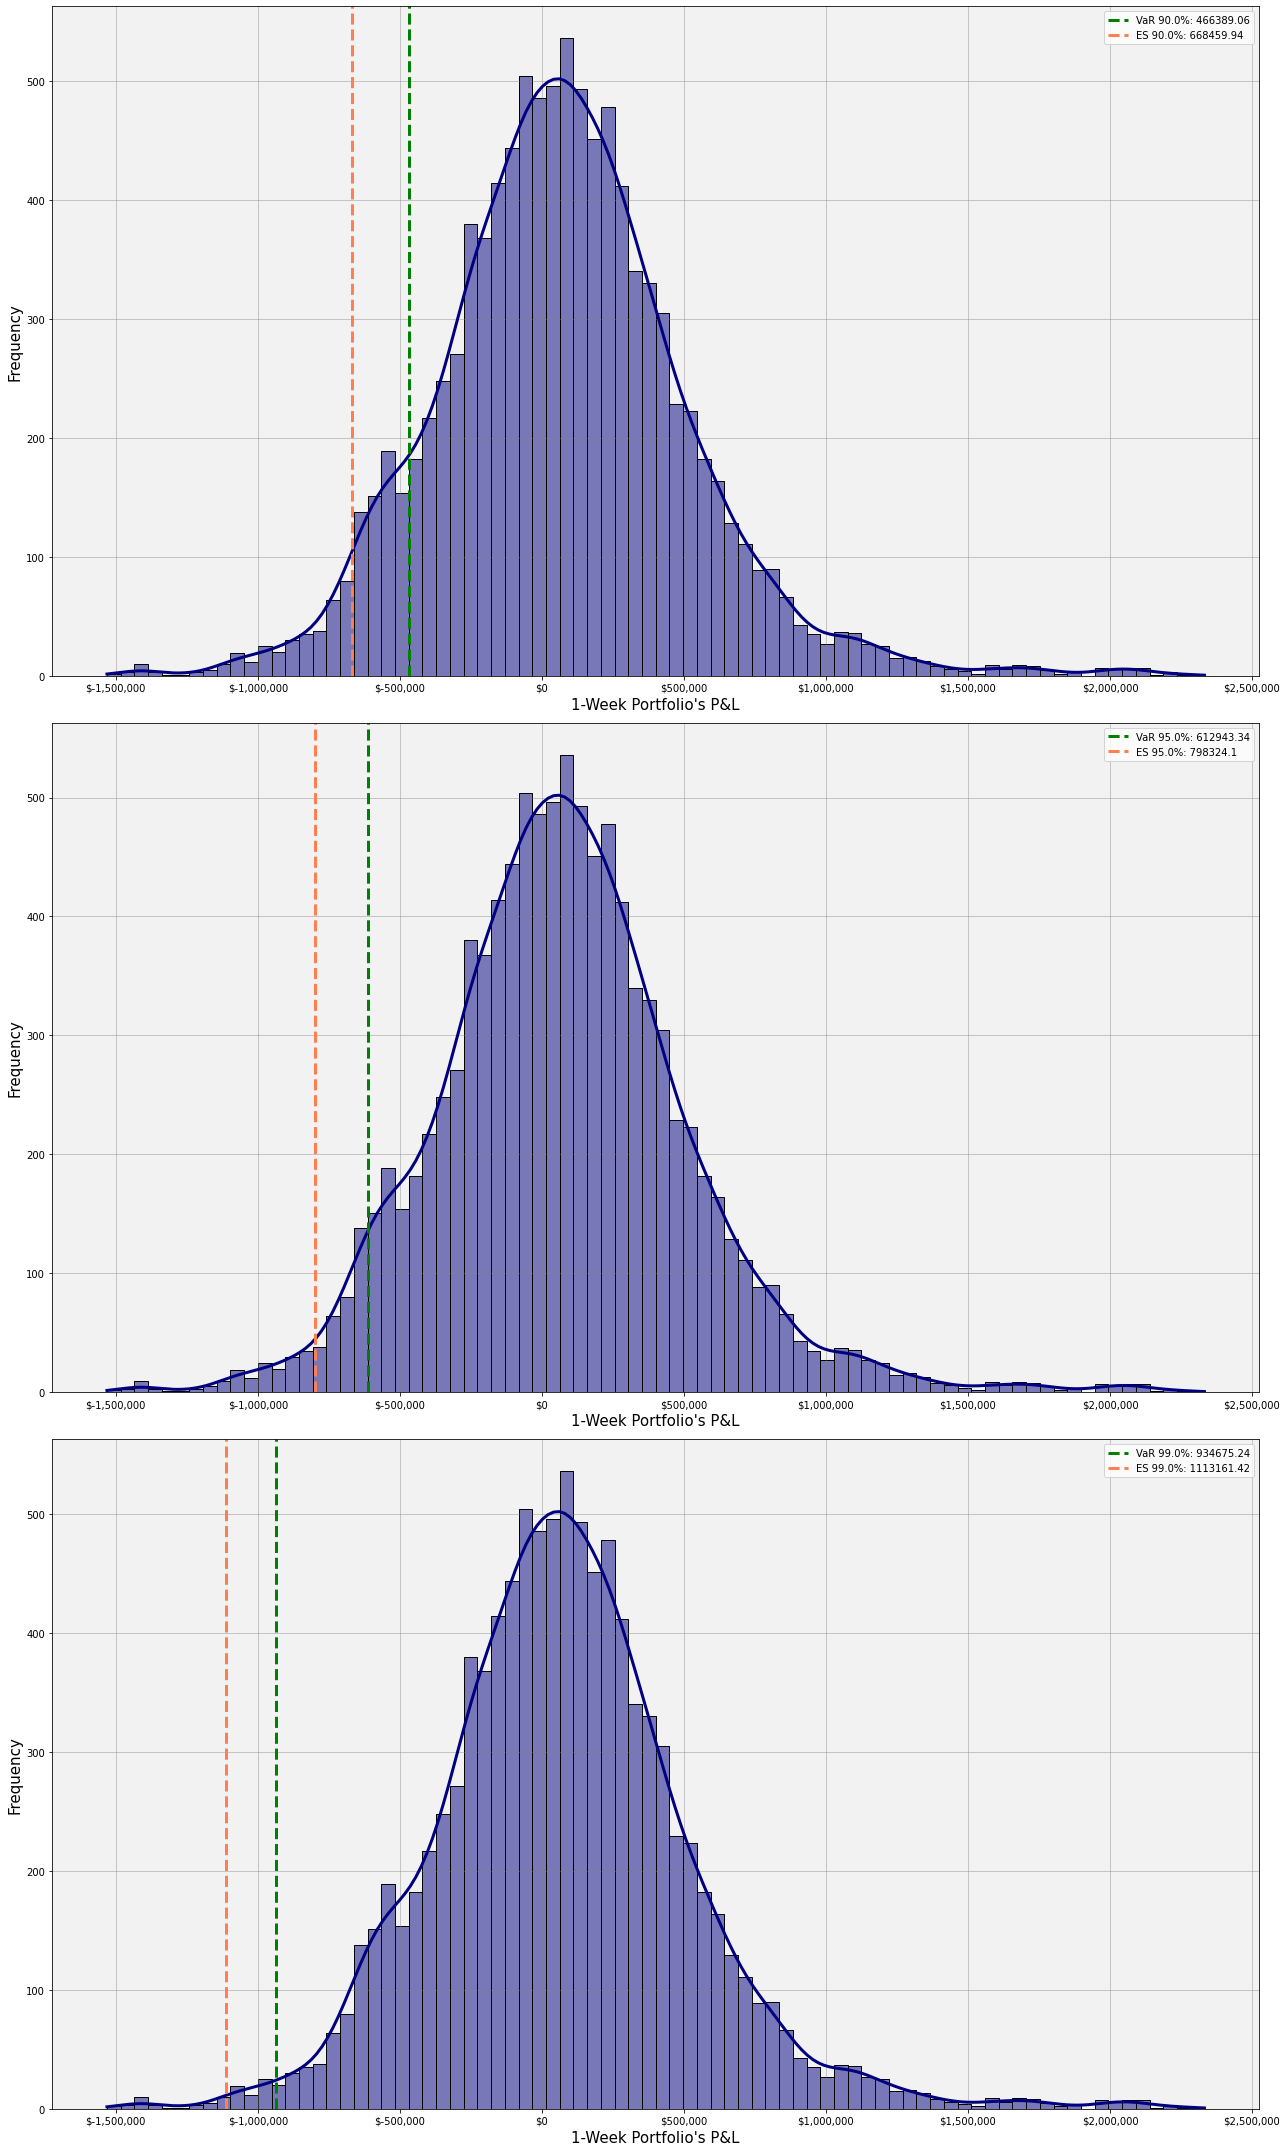

In [26]:
p_simvalueM1, VaR_historical_M1, ES_historical_M1 = simulation_VaR_ES(R1_M1, R2_M1, lambda1_f = 0.3, lambda2_f = 0.7,
                                                                      W0 = 10000000, conf_lvls = [0.90, 0.95, 0.99],
                                                                      plot = True, print_output = True, M1 = True)

# Exercise (iii)

## M2

For M2, compute $VaR_{\alpha}$ and $ES_{\alpha}$ by simulating $10,000$ bivariate Gaussian returns with mean $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$, both estimated earlier in (i).

The value-at-risk for the confidence level 90.0% is 520354.06.
The expected shortfall for the confidence level 90.0% is 751359.79.

The value-at-risk for the confidence level 95.0% is 697828.33.
The expected shortfall for the confidence level 95.0% is 901996.1.

The value-at-risk for the confidence level 99.0% is 1030690.85.
The expected shortfall for the confidence level 99.0% is 1194433.93.



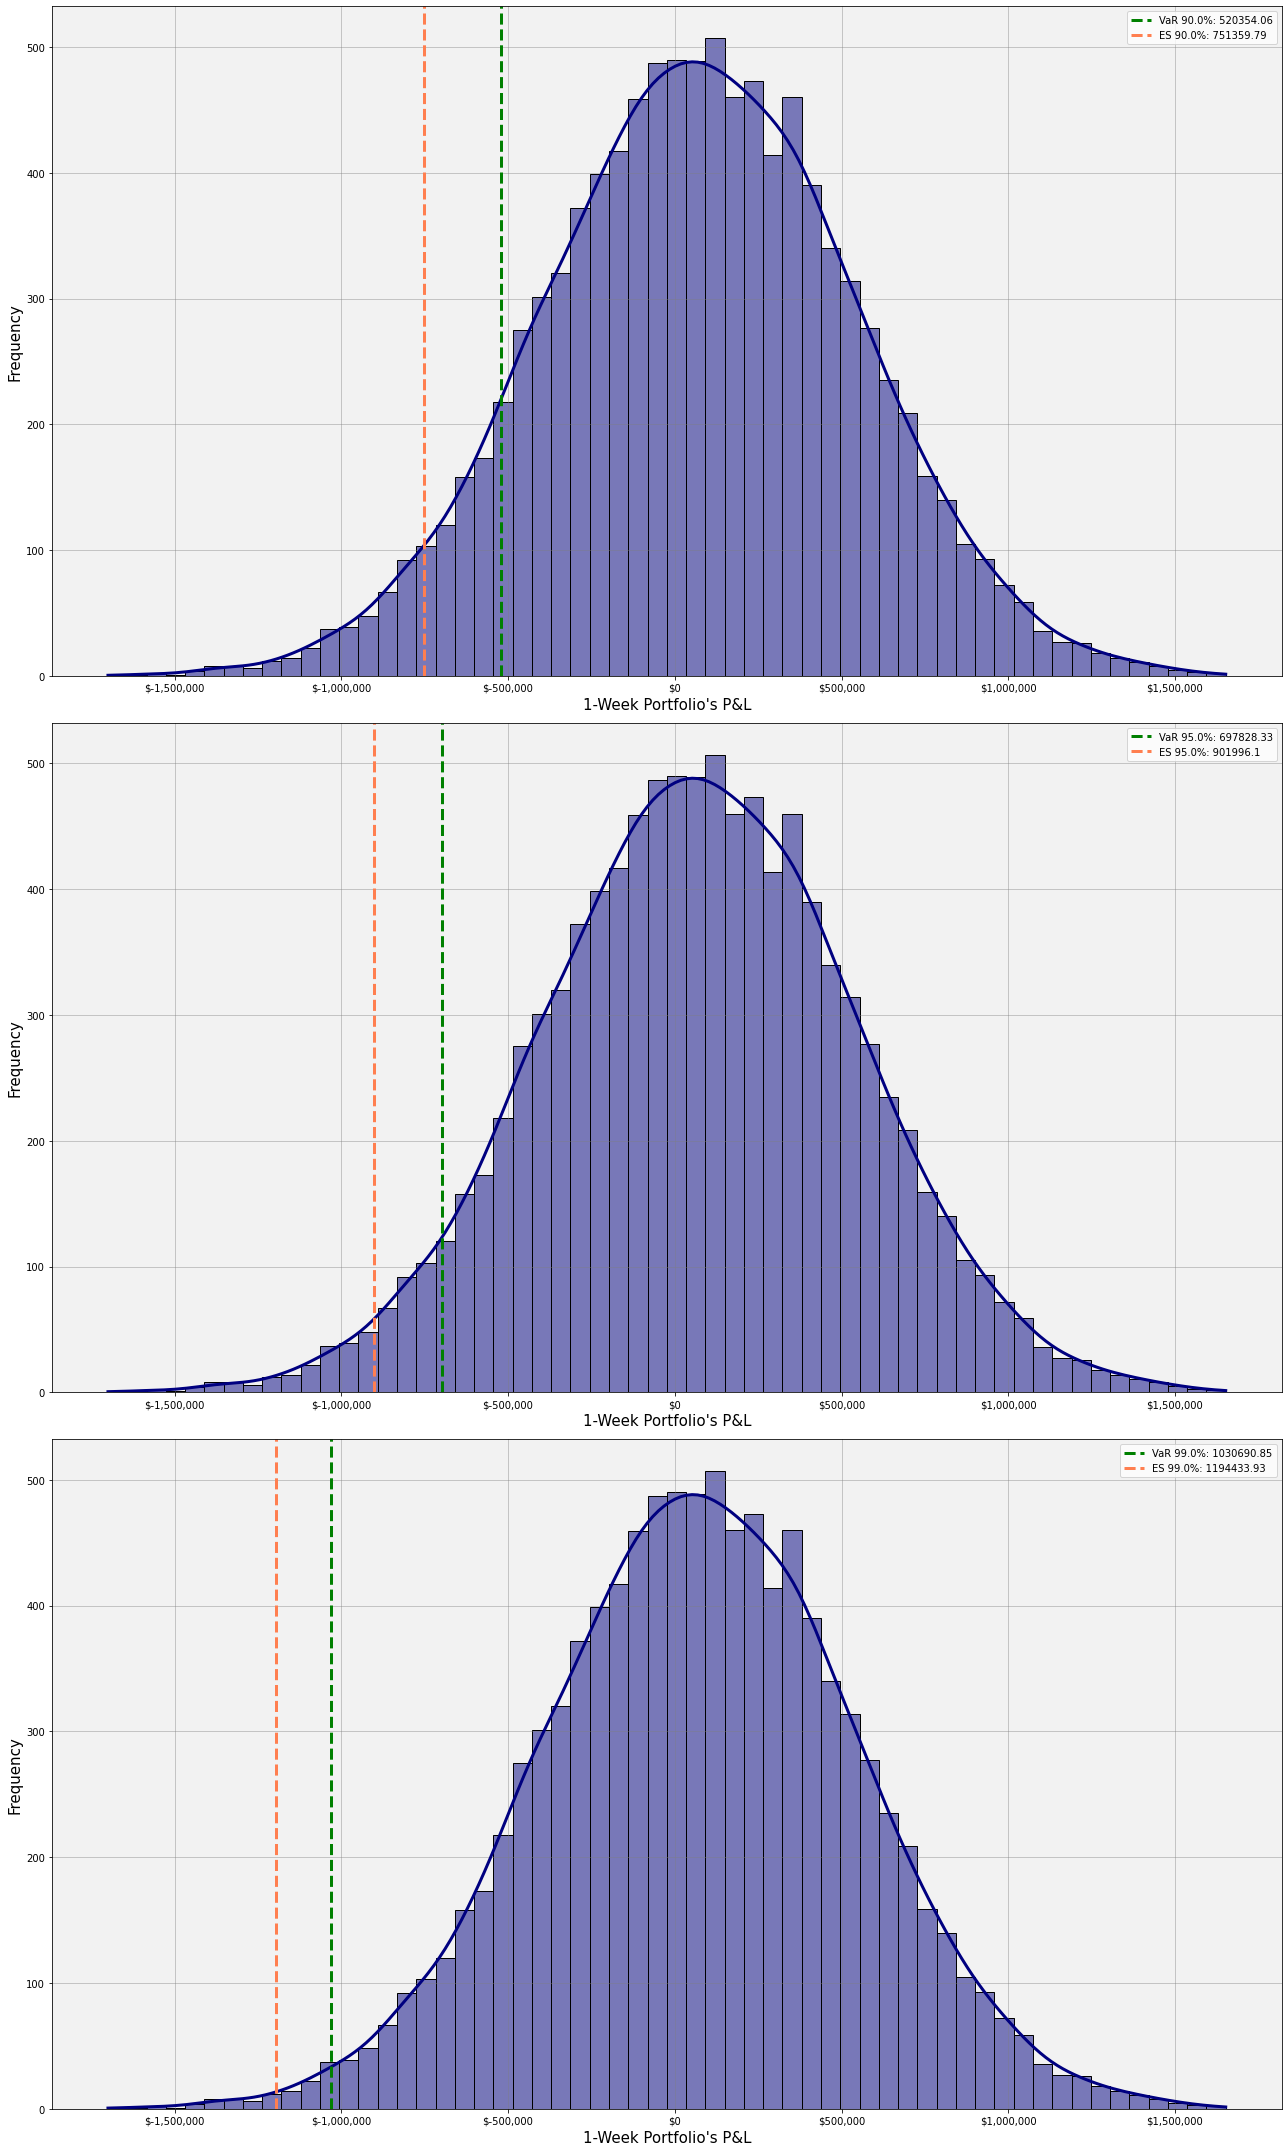

In [27]:
p_simvalueM2, VaR_historical_M2, ES_historical_M2 = simulation_VaR_ES(R1_M1, R2_M1, conf_lvls = [0.90, 0.95, 0.99], lambda1_f = 0.3, lambda2_f = 0.7,
                                                                      W0 = 10000000,
                                                                      plot = True, print_output = True, M2 = True)

## M4

For M4, we calculate the returns as outlined in Section 4.3.3 of the assignment.

The value-at-risk for the confidence level 90.0% is 556738.03.
The expected shortfall for the confidence level 90.0% is 814300.27.

The value-at-risk for the confidence level 95.0% is 752038.12.
The expected shortfall for the confidence level 95.0% is 981586.5.

The value-at-risk for the confidence level 99.0% is 1127701.0.
The expected shortfall for the confidence level 99.0% is 1348962.45.



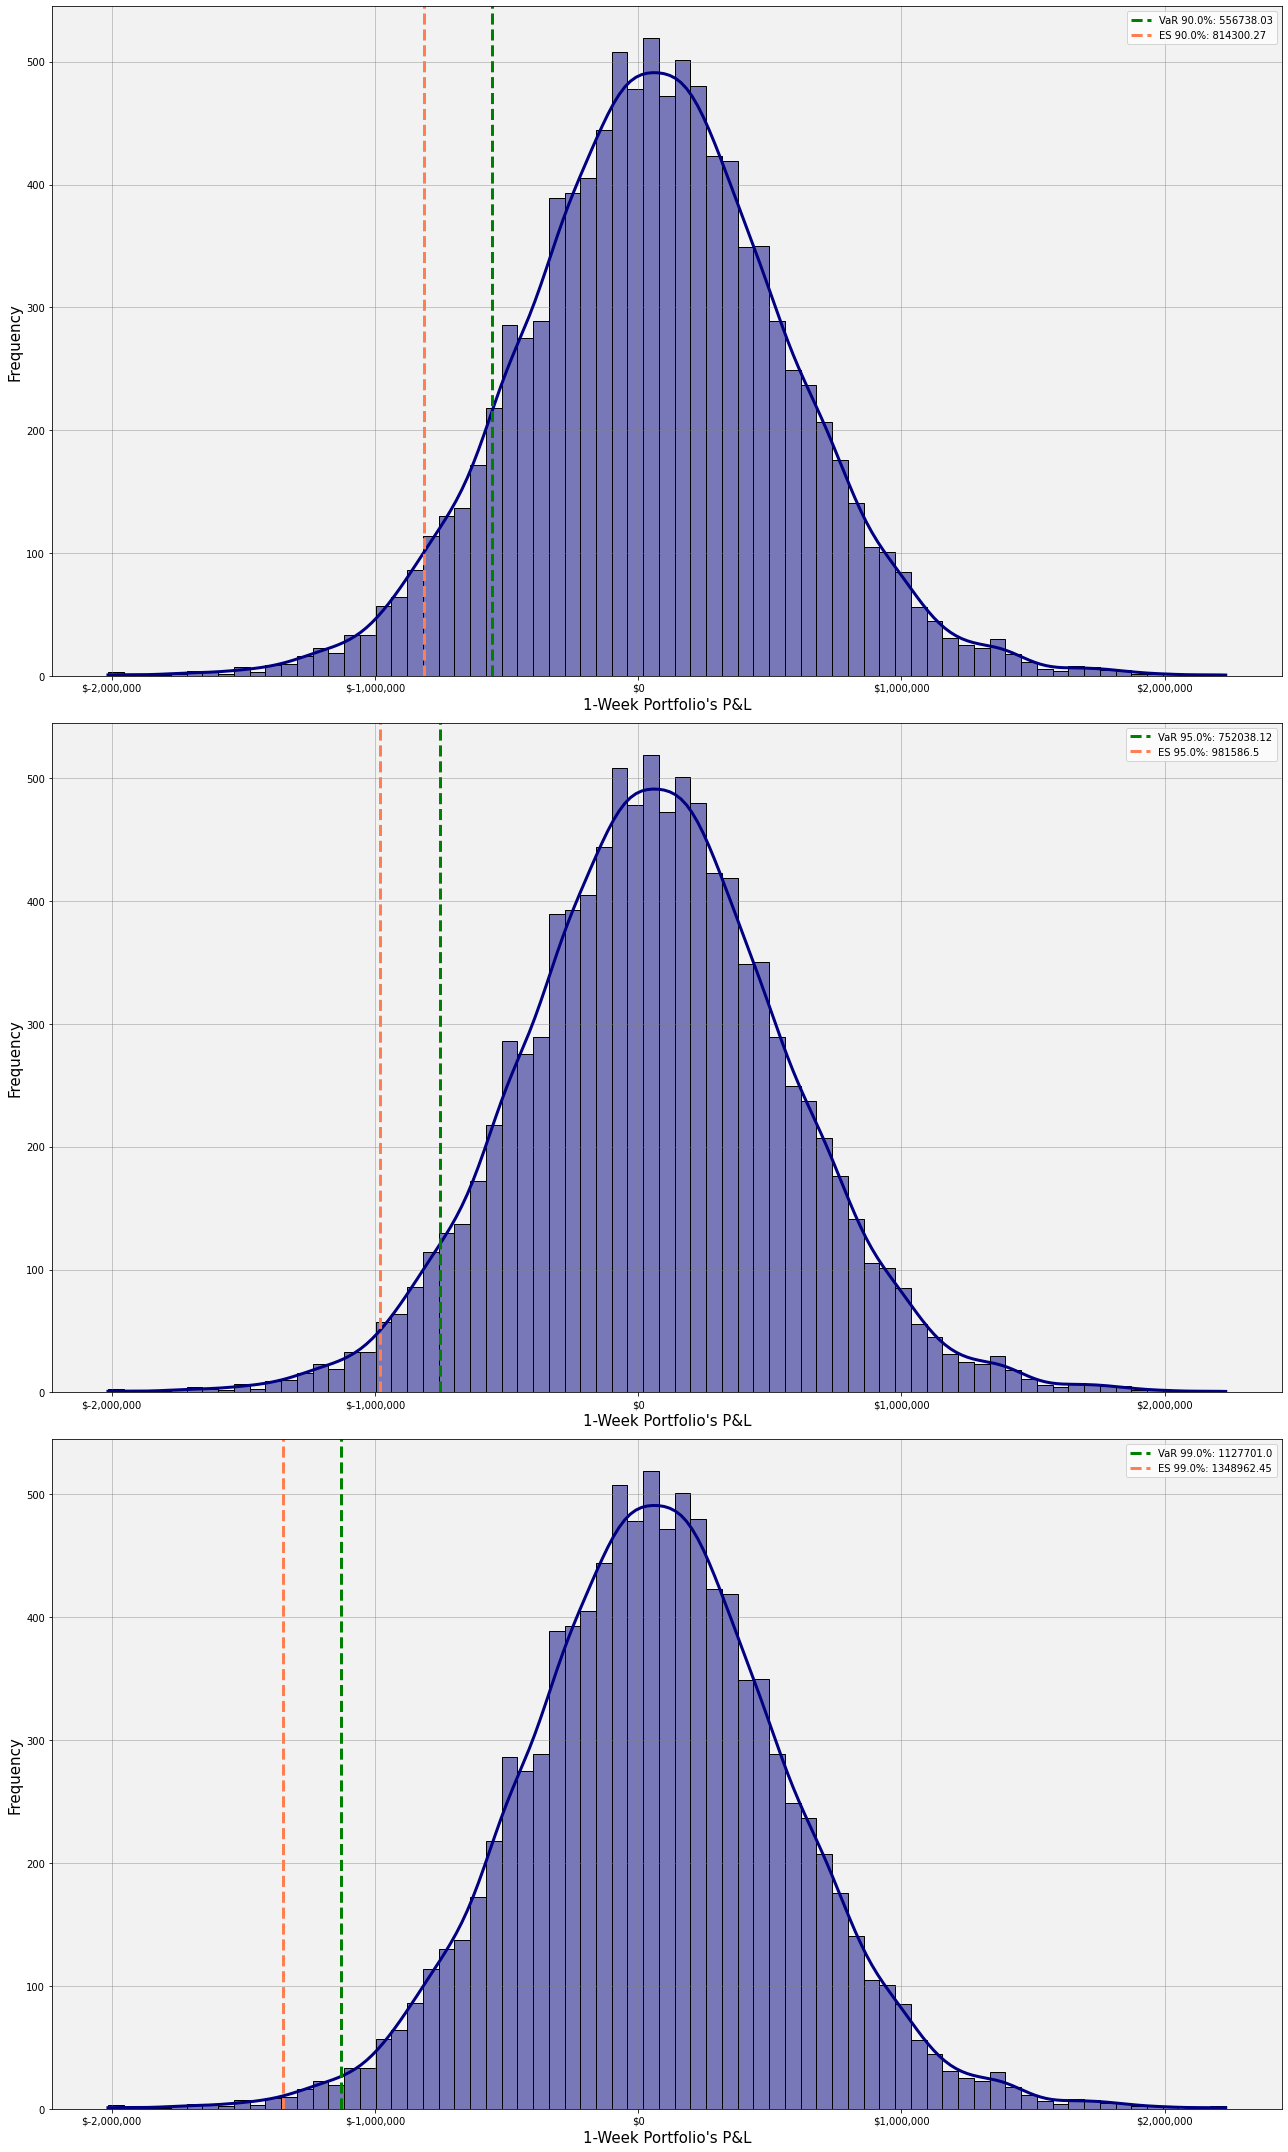

In [28]:
p_simvalueM4, VaR_historical_M4, ES_historical_M4 = simulation_VaR_ES(R1_M1, R2_M1, lambda1_f = 0.3, lambda2_f = 0.7,
                                                                      W0 = 10000000, conf_lvls = [0.90, 0.95, 0.99],
                                                                      plot = True, print_output = True, M4 = True)

# Exercise (iv)

## M1

What is the impact of the last $N = 100, 200, 300, 400$ observations of 1-week returns on M1?

In [29]:
def impact_lastobs(R1_M1_f, R2_M1_f, obs = [100, 200, 300, 400], M1 = False, M2 = False, M4 = False):
    """
    Runs a simulation on the last n observations, computes VaR and ES and plots them
    
    Parameters:
    R1_M1_f: empirical returns of SREN.SW
    R2_M1_f: empirical returns of NVDA.US
    obs: list of last observations
    M1: if true, simulates VaR and ES for M1
    M2: if true, simulates VaR and ES for M2
    M4: if true, simulates VaR and ES for M4
    """
    len_returns = len(R1_M1_f) # length dataframe
    
    for last_obs in obs:
        R1_M1_last = R1_M1_f[(len_returns-last_obs):len_returns]
        R2_M1_last = R2_M1_f[(len_returns-last_obs):len_returns]
        print("-"*80)
        print("SIMULATION FOR THE LAST {} OBSERVATIONS".format(last_obs))
        
        if M1 == True:
            p_simvalueM1_last, VaR_historical_M1_last, ES_historical_M1_last = simulation_VaR_ES(R1_M1_last, R2_M1_last,
                                                                                                 lambda1_f = 0.3, lambda2_f = 0.7,
                                                                                                 W0 = 10000000, conf_lvls = [0.90, 0.95, 0.99],
                                                                                                 plot = True, print_output = True, M1 = True)
        
        elif M2 == True:
            p_simvalueM2_last, VaR_historical_M2_last, ES_historical_M2_last = simulation_VaR_ES(R1_M1_last, R2_M1_last,
                                                                                                 lambda1_f = 0.3, lambda2_f = 0.7, 
                                                                                                 W0 = 10000000, conf_lvls = [0.90, 0.95, 0.99],
                                                                                                 plot = True, print_output = True, M2 = True)
        
        elif M4 == True:
            p_simvalueM4_last, VaR_historical_M4_last, ES_historical_M4_last = simulation_VaR_ES(R1_M1_last, R2_M1_last,
                                                                                                 lambda1_f = 0.3, lambda2_f = 0.7,
                                                                                                 W0 = 10000000, conf_lvls = [0.90, 0.95, 0.99],
                                                                                                 plot = True, print_output = True, M4 = True)

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 100 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 364428.41.
The expected shortfall for the confidence level 90.0% is 600026.68.

The value-at-risk for the confidence level 95.0% is 554691.92.
The expected shortfall for the confidence level 95.0% is 744034.17.

The value-at-risk for the confidence level 99.0% is 946941.39.
The expected shortfall for the confidence level 99.0% is 1004748.31.



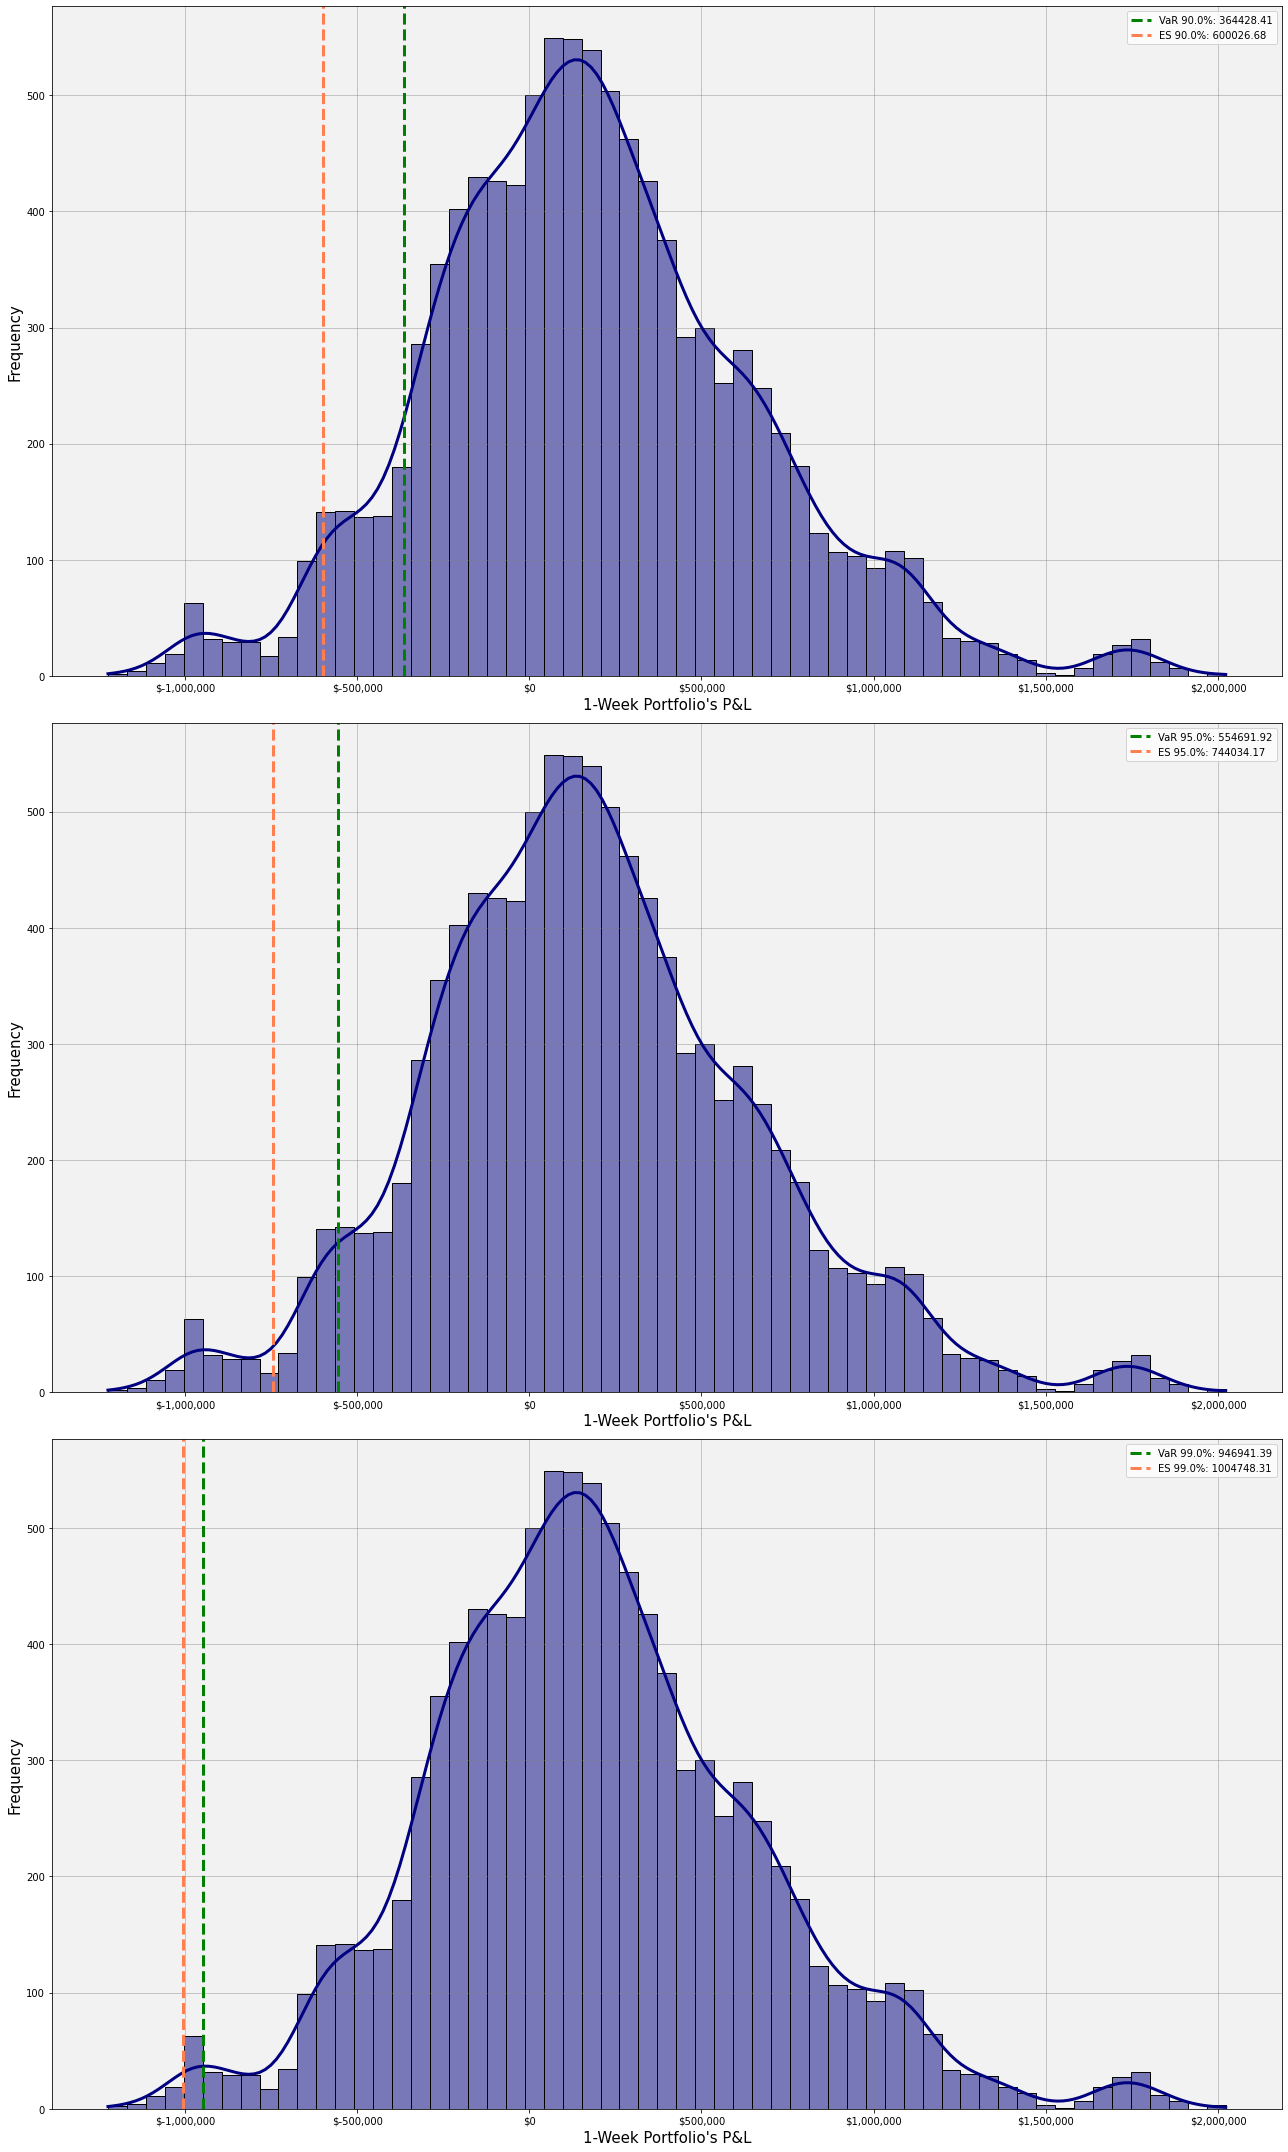

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 200 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 495462.55.
The expected shortfall for the confidence level 90.0% is 717226.37.

The value-at-risk for the confidence level 95.0% is 638113.94.
The expected shortfall for the confidence level 95.0% is 873125.48.

The value-at-risk for the confidence level 99.0% is 1022965.77.
The expected shortfall for the confidence level 99.0% is 1099110.54.



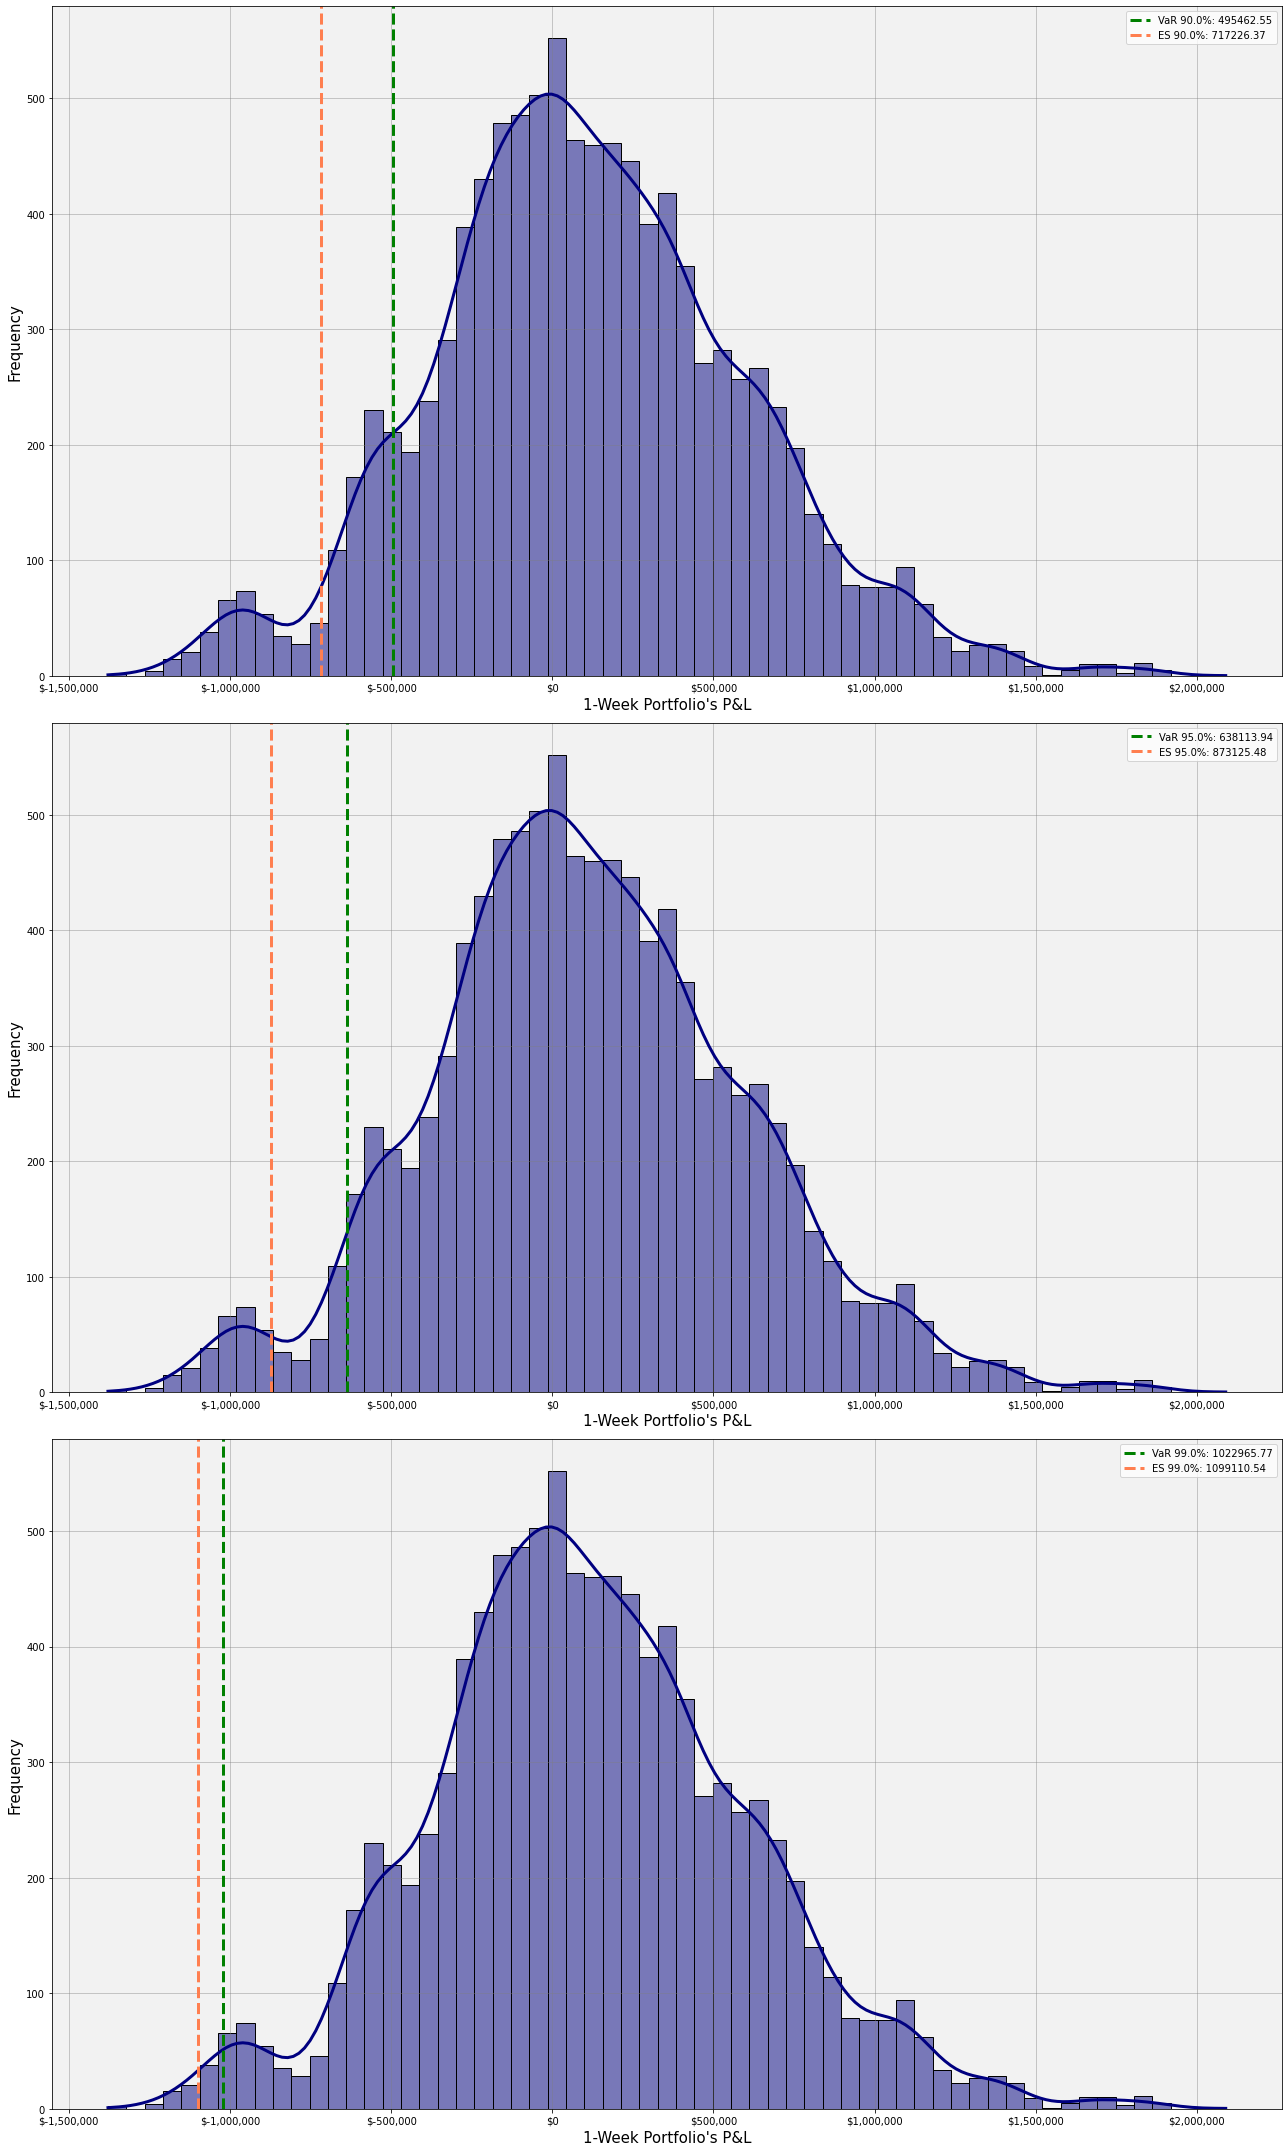

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 300 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 496492.3.
The expected shortfall for the confidence level 90.0% is 706565.9.

The value-at-risk for the confidence level 95.0% is 633866.54.
The expected shortfall for the confidence level 95.0% is 851322.55.

The value-at-risk for the confidence level 99.0% is 1012862.03.
The expected shortfall for the confidence level 99.0% is 1129685.03.



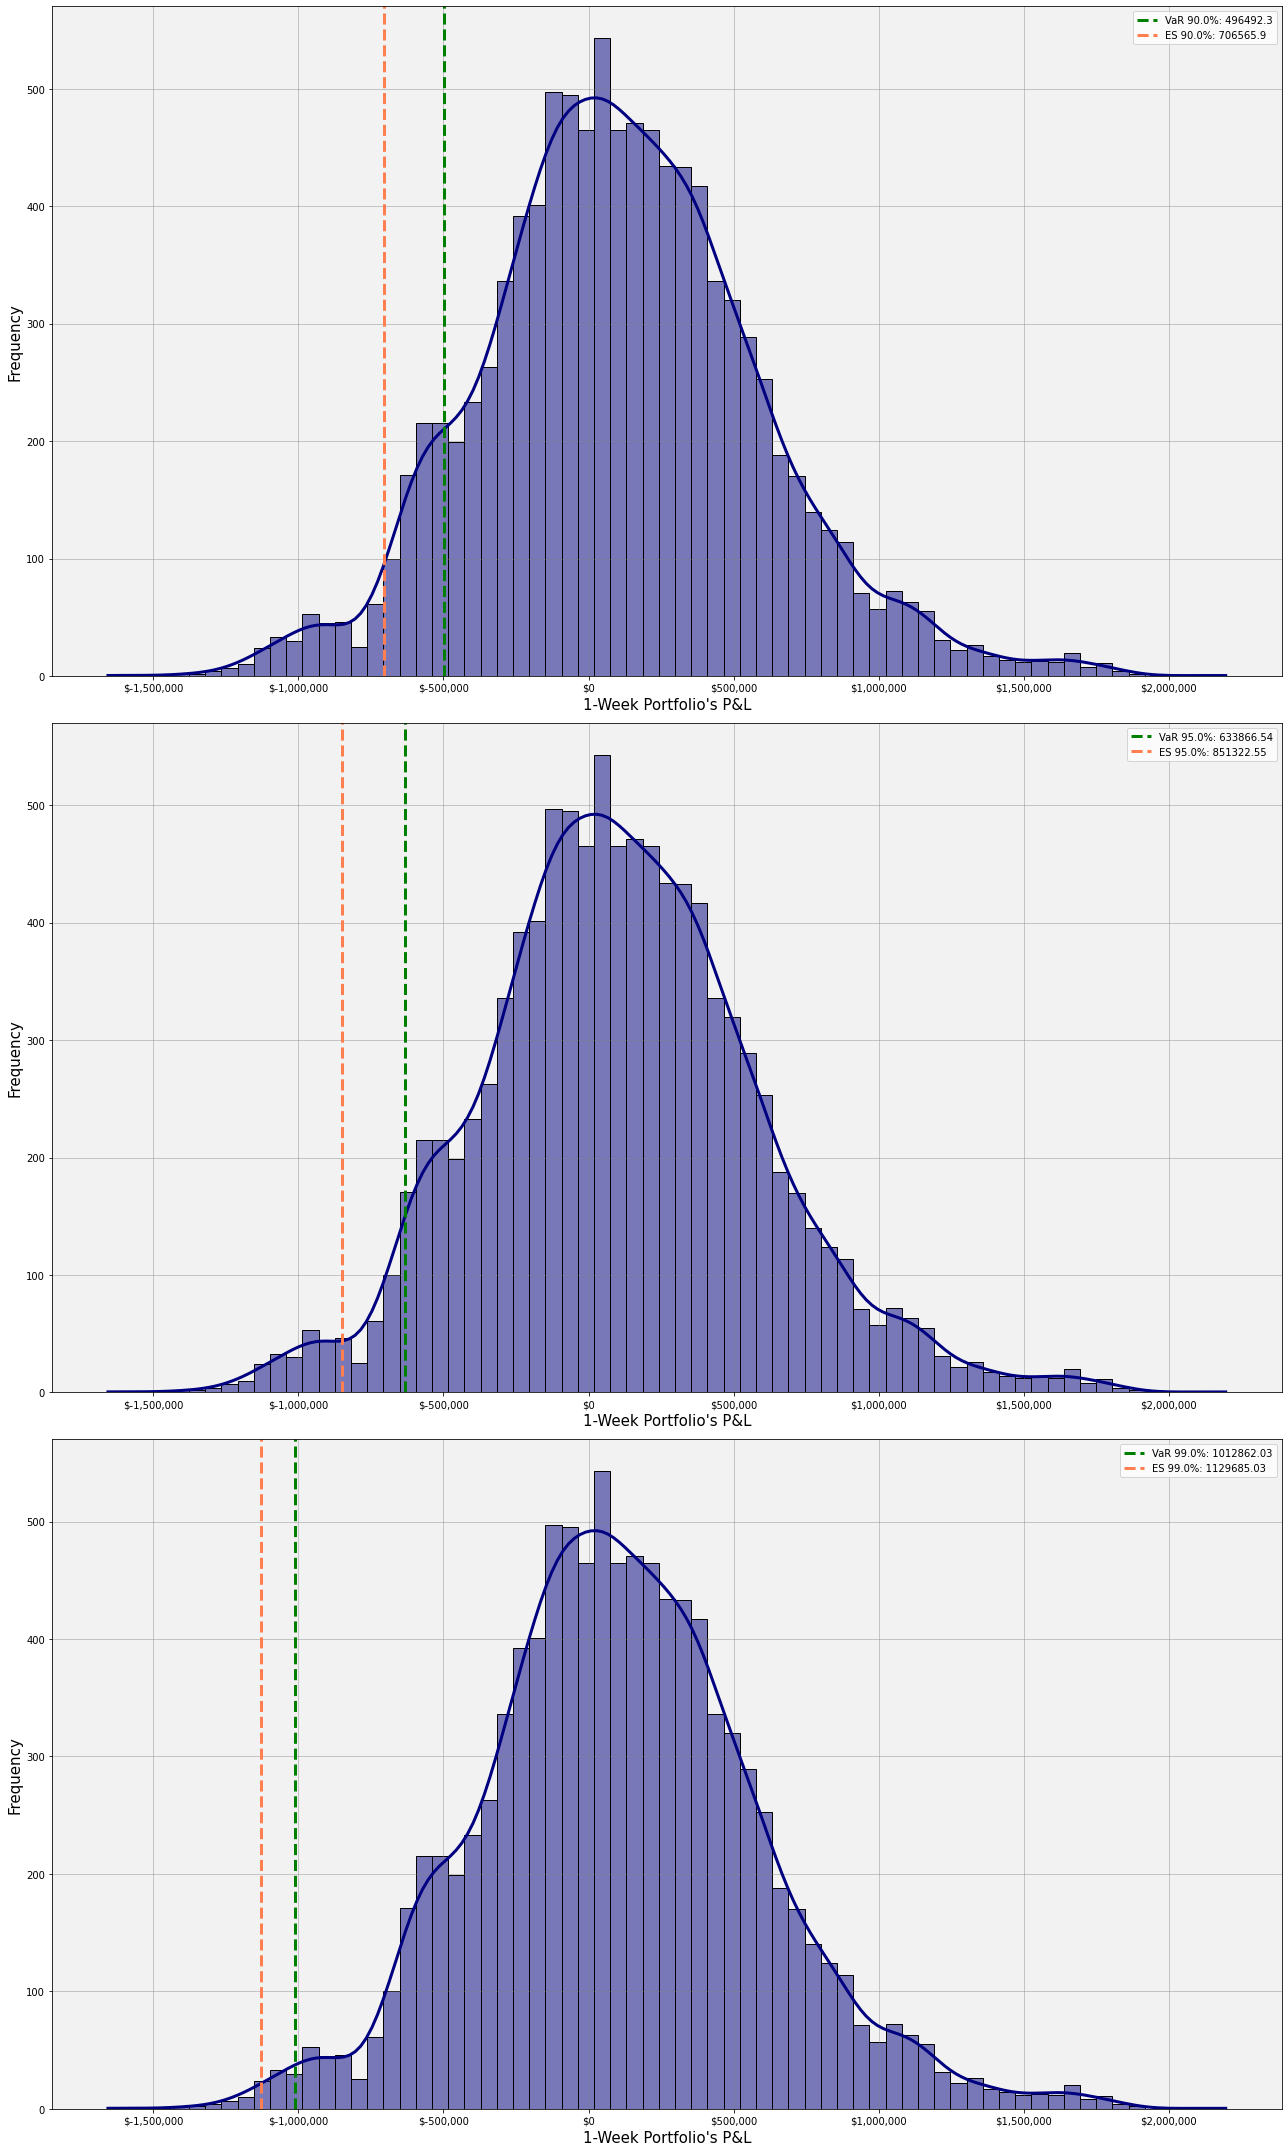

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 400 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 489847.64.
The expected shortfall for the confidence level 90.0% is 713261.17.

The value-at-risk for the confidence level 95.0% is 631996.04.
The expected shortfall for the confidence level 95.0% is 868414.26.

The value-at-risk for the confidence level 99.0% is 1012062.51.
The expected shortfall for the confidence level 99.0% is 1181434.24.



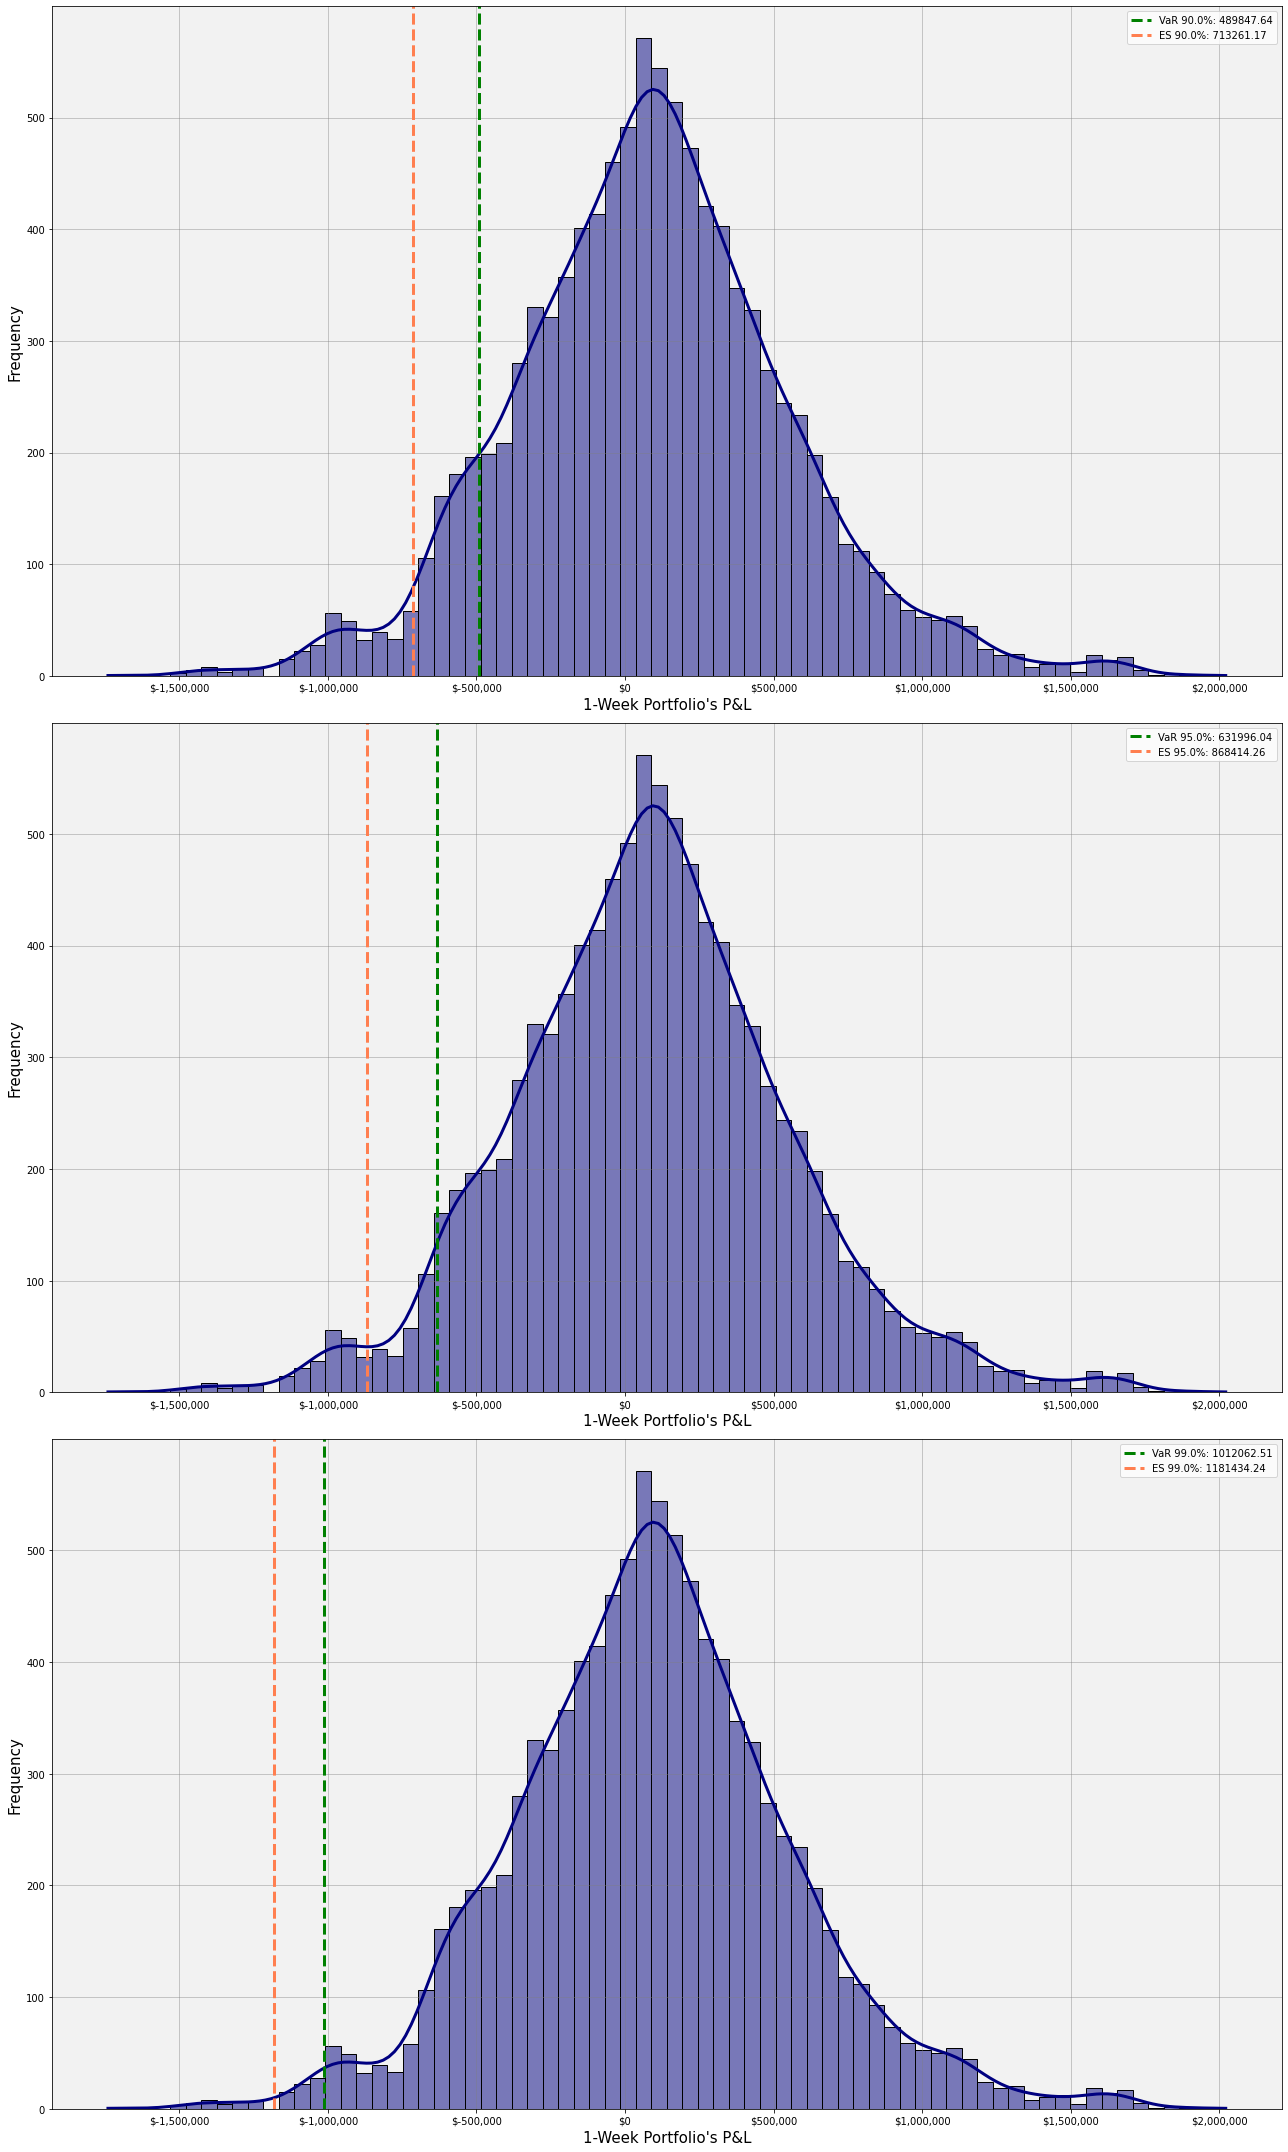

In [30]:
impact_lastobs(R1_M1, R2_M1, M1 = True)

## M2

And the impact on M2?

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 100 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 436180.9.
The expected shortfall for the confidence level 90.0% is 677606.31.

The value-at-risk for the confidence level 95.0% is 623230.8.
The expected shortfall for the confidence level 95.0% is 836839.23.

The value-at-risk for the confidence level 99.0% is 977387.34.
The expected shortfall for the confidence level 99.0% is 1152517.45.



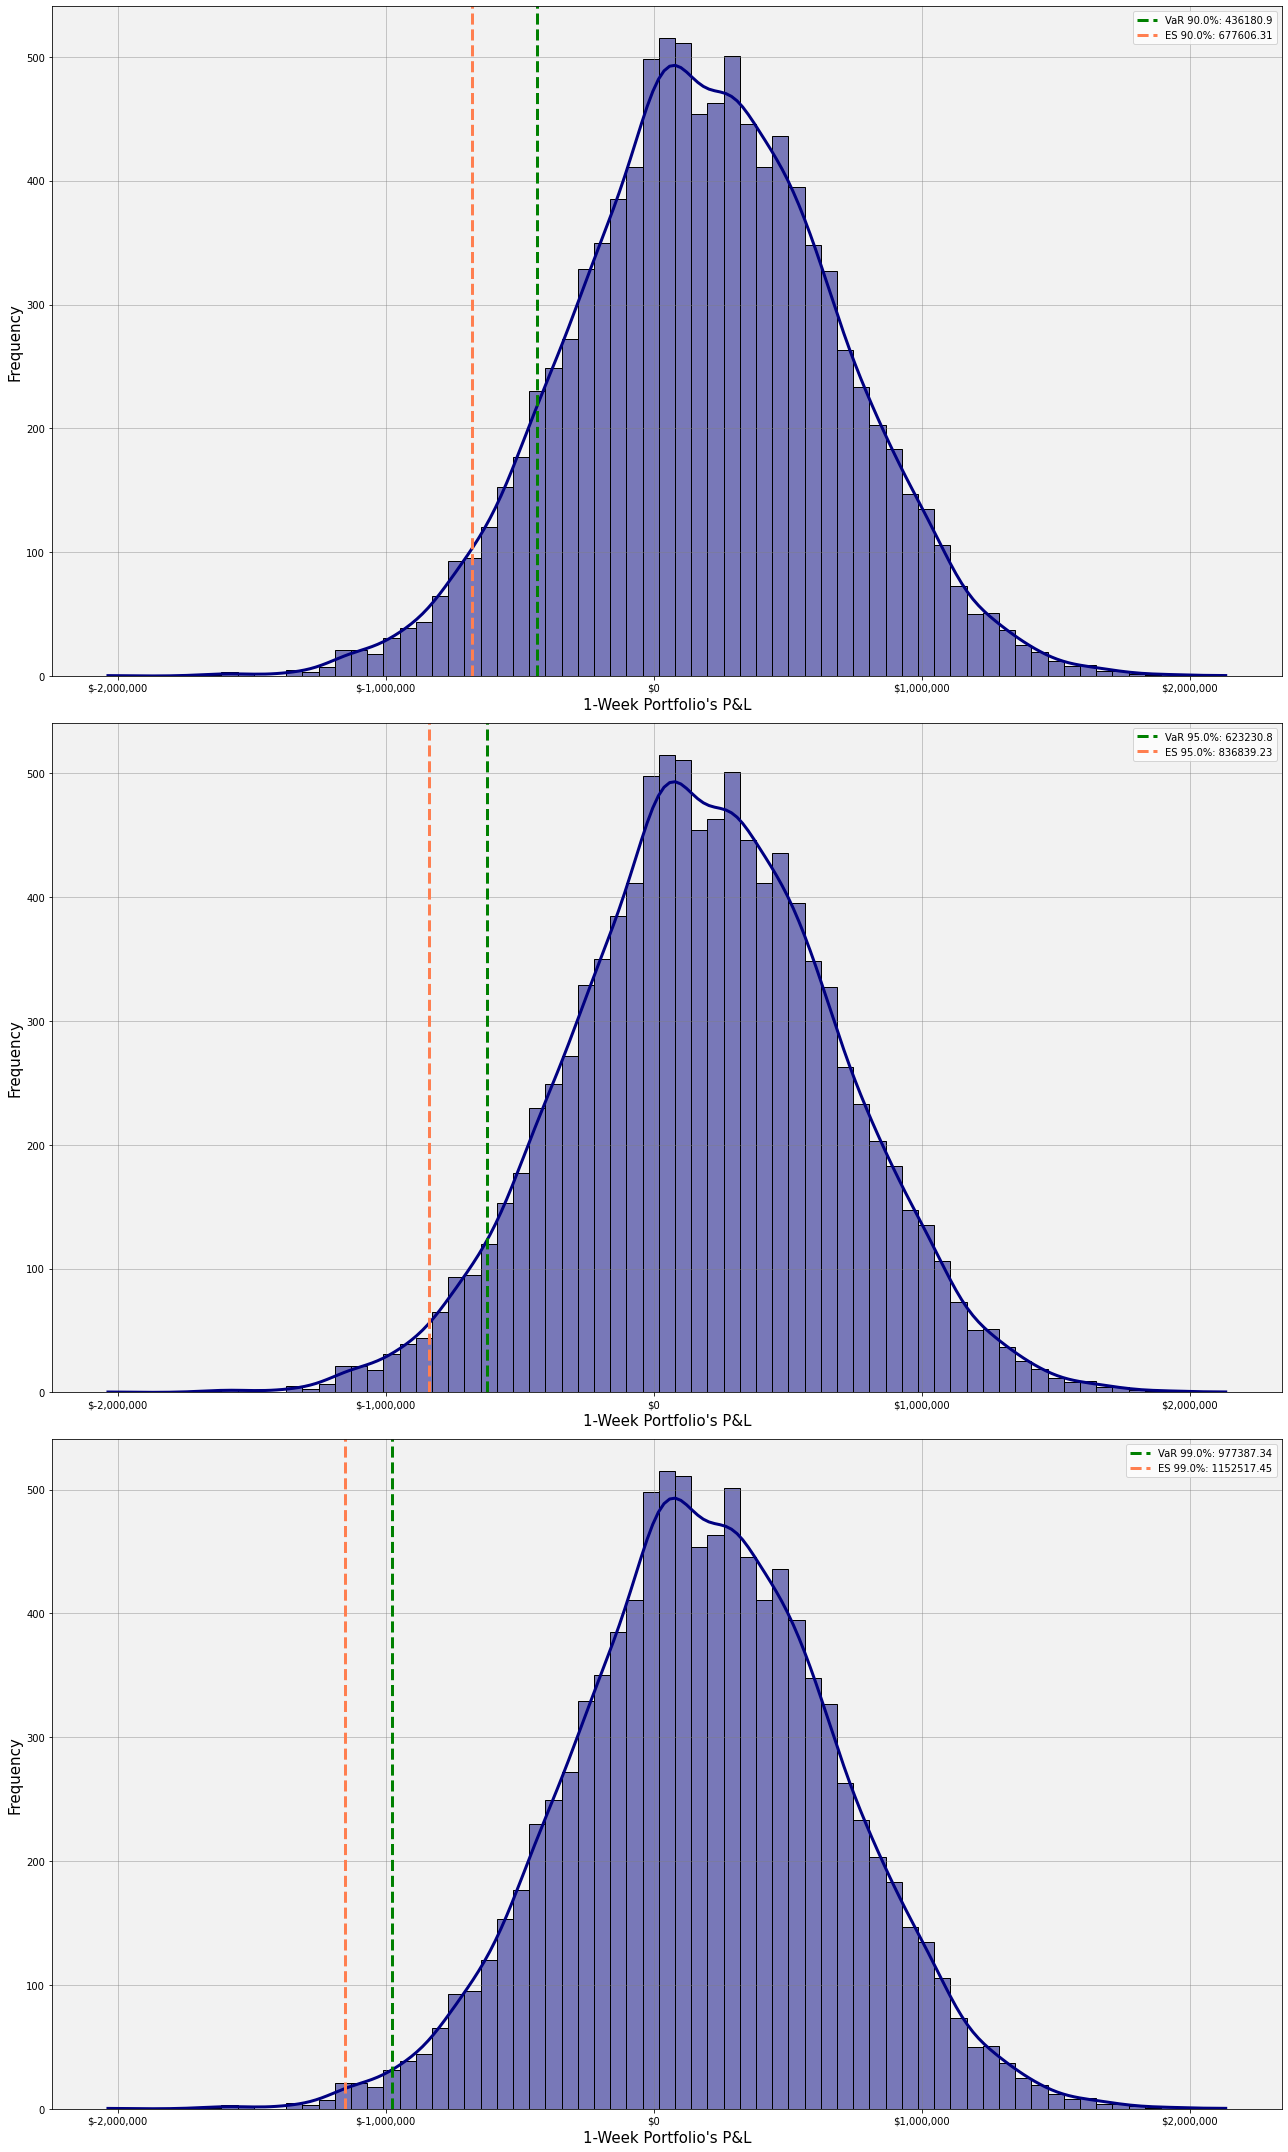

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 200 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 538276.56.
The expected shortfall for the confidence level 90.0% is 781433.3.

The value-at-risk for the confidence level 95.0% is 735737.47.
The expected shortfall for the confidence level 95.0% is 938805.63.

The value-at-risk for the confidence level 99.0% is 1051426.48.
The expected shortfall for the confidence level 99.0% is 1228756.6.



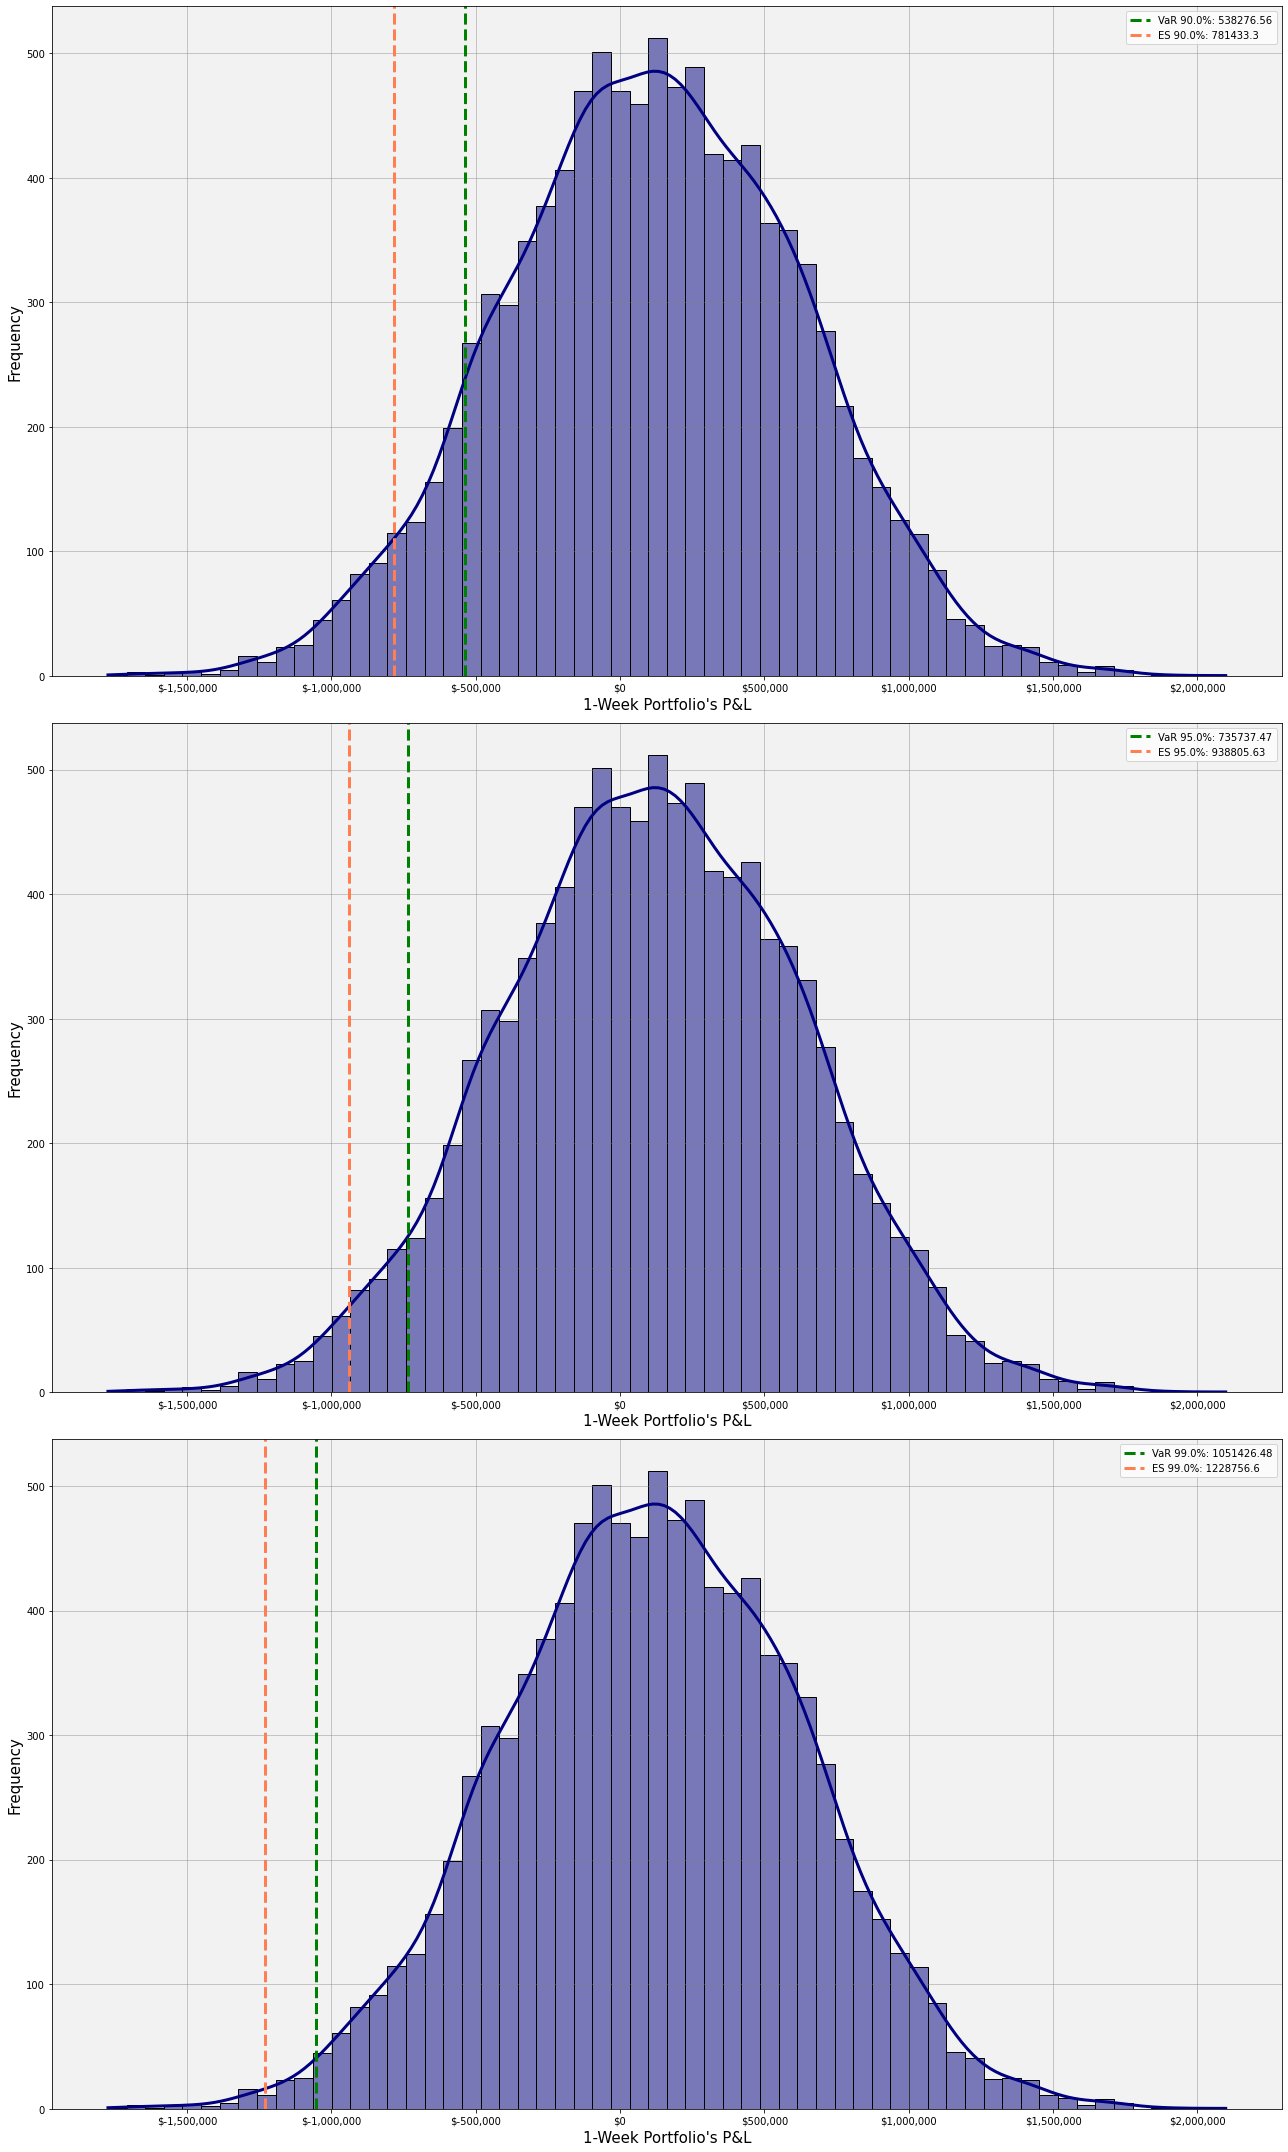

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 300 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 529107.54.
The expected shortfall for the confidence level 90.0% is 776057.82.

The value-at-risk for the confidence level 95.0% is 728284.71.
The expected shortfall for the confidence level 95.0% is 927970.37.

The value-at-risk for the confidence level 99.0% is 1053047.93.
The expected shortfall for the confidence level 99.0% is 1225234.91.



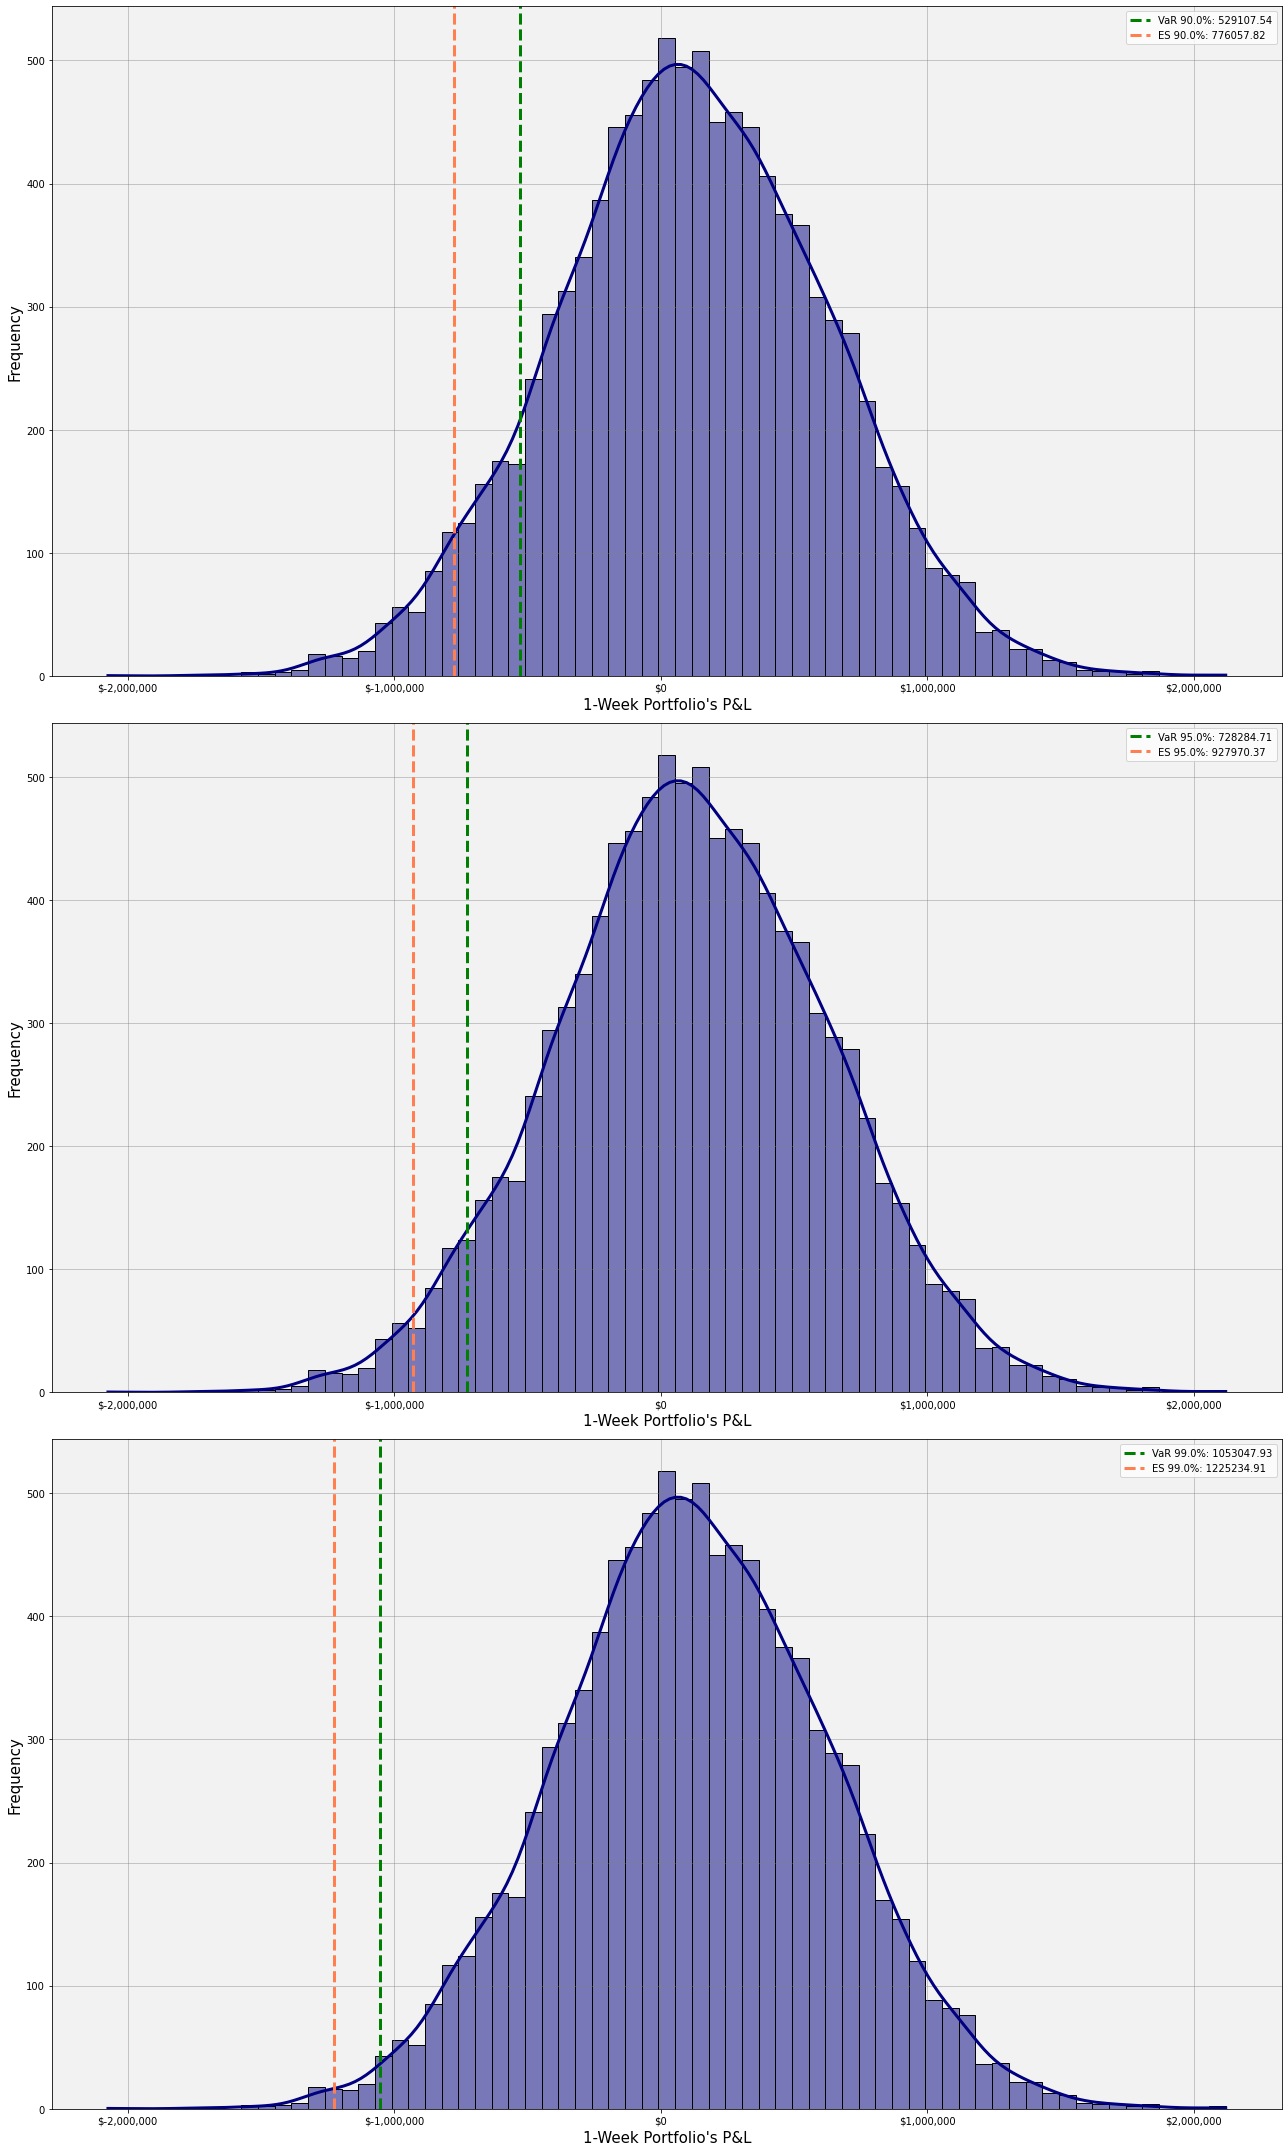

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 400 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 549414.95.
The expected shortfall for the confidence level 90.0% is 776556.3.

The value-at-risk for the confidence level 95.0% is 719236.25.
The expected shortfall for the confidence level 95.0% is 924441.15.

The value-at-risk for the confidence level 99.0% is 1058066.14.
The expected shortfall for the confidence level 99.0% is 1224347.59.



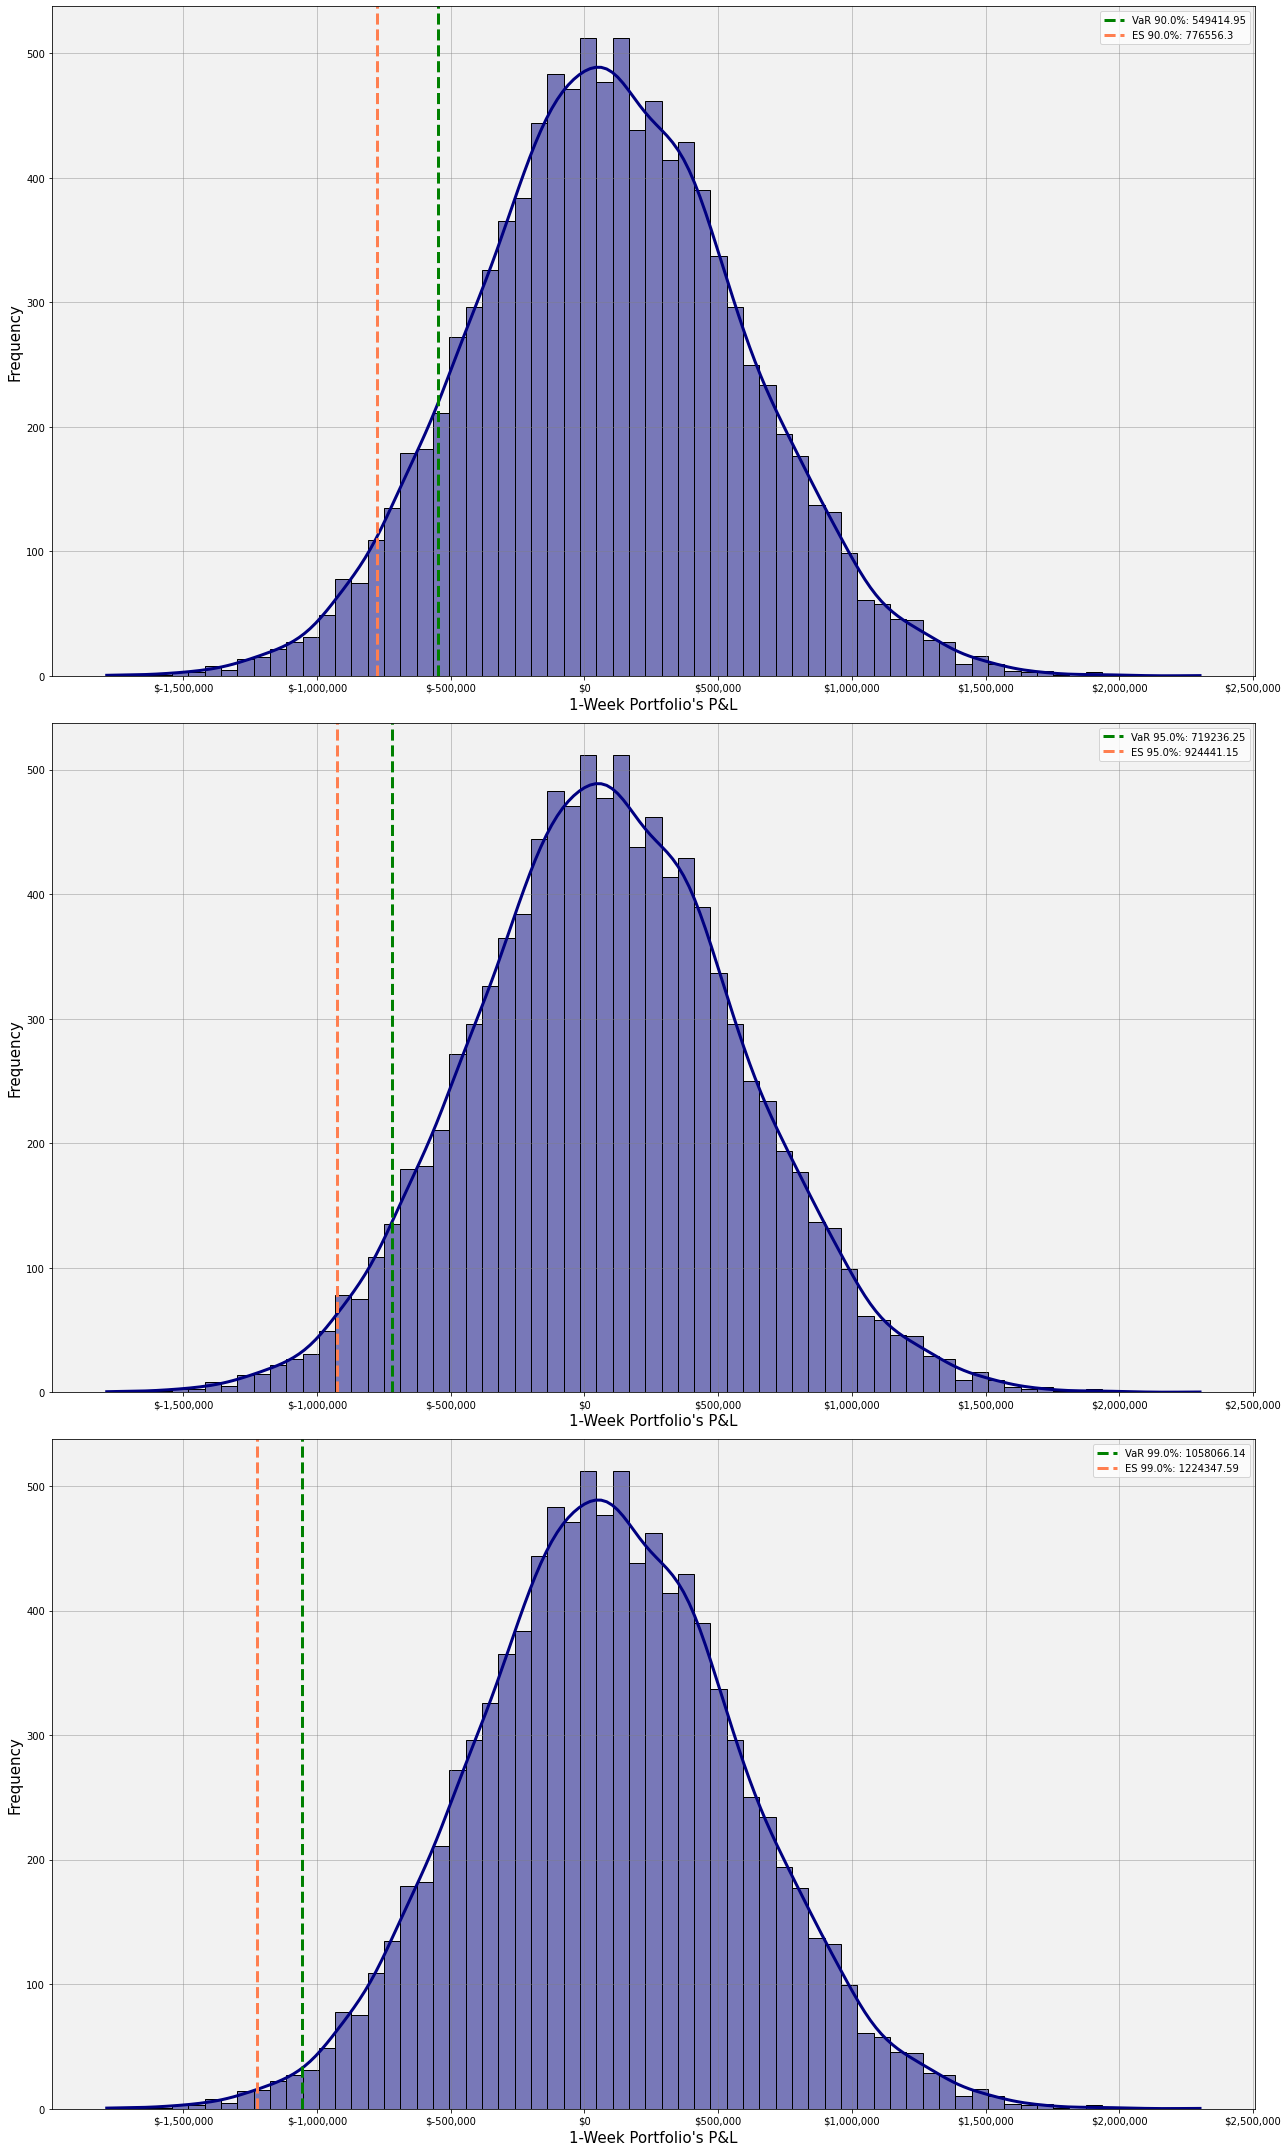

In [31]:
impact_lastobs(R1_M1, R2_M1, M2 = True)

## M4

And on M4?

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 100 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 459792.31.
The expected shortfall for the confidence level 90.0% is 707471.85.

The value-at-risk for the confidence level 95.0% is 641257.75.
The expected shortfall for the confidence level 95.0% is 870447.47.

The value-at-risk for the confidence level 99.0% is 1011912.67.
The expected shortfall for the confidence level 99.0% is 1188279.18.



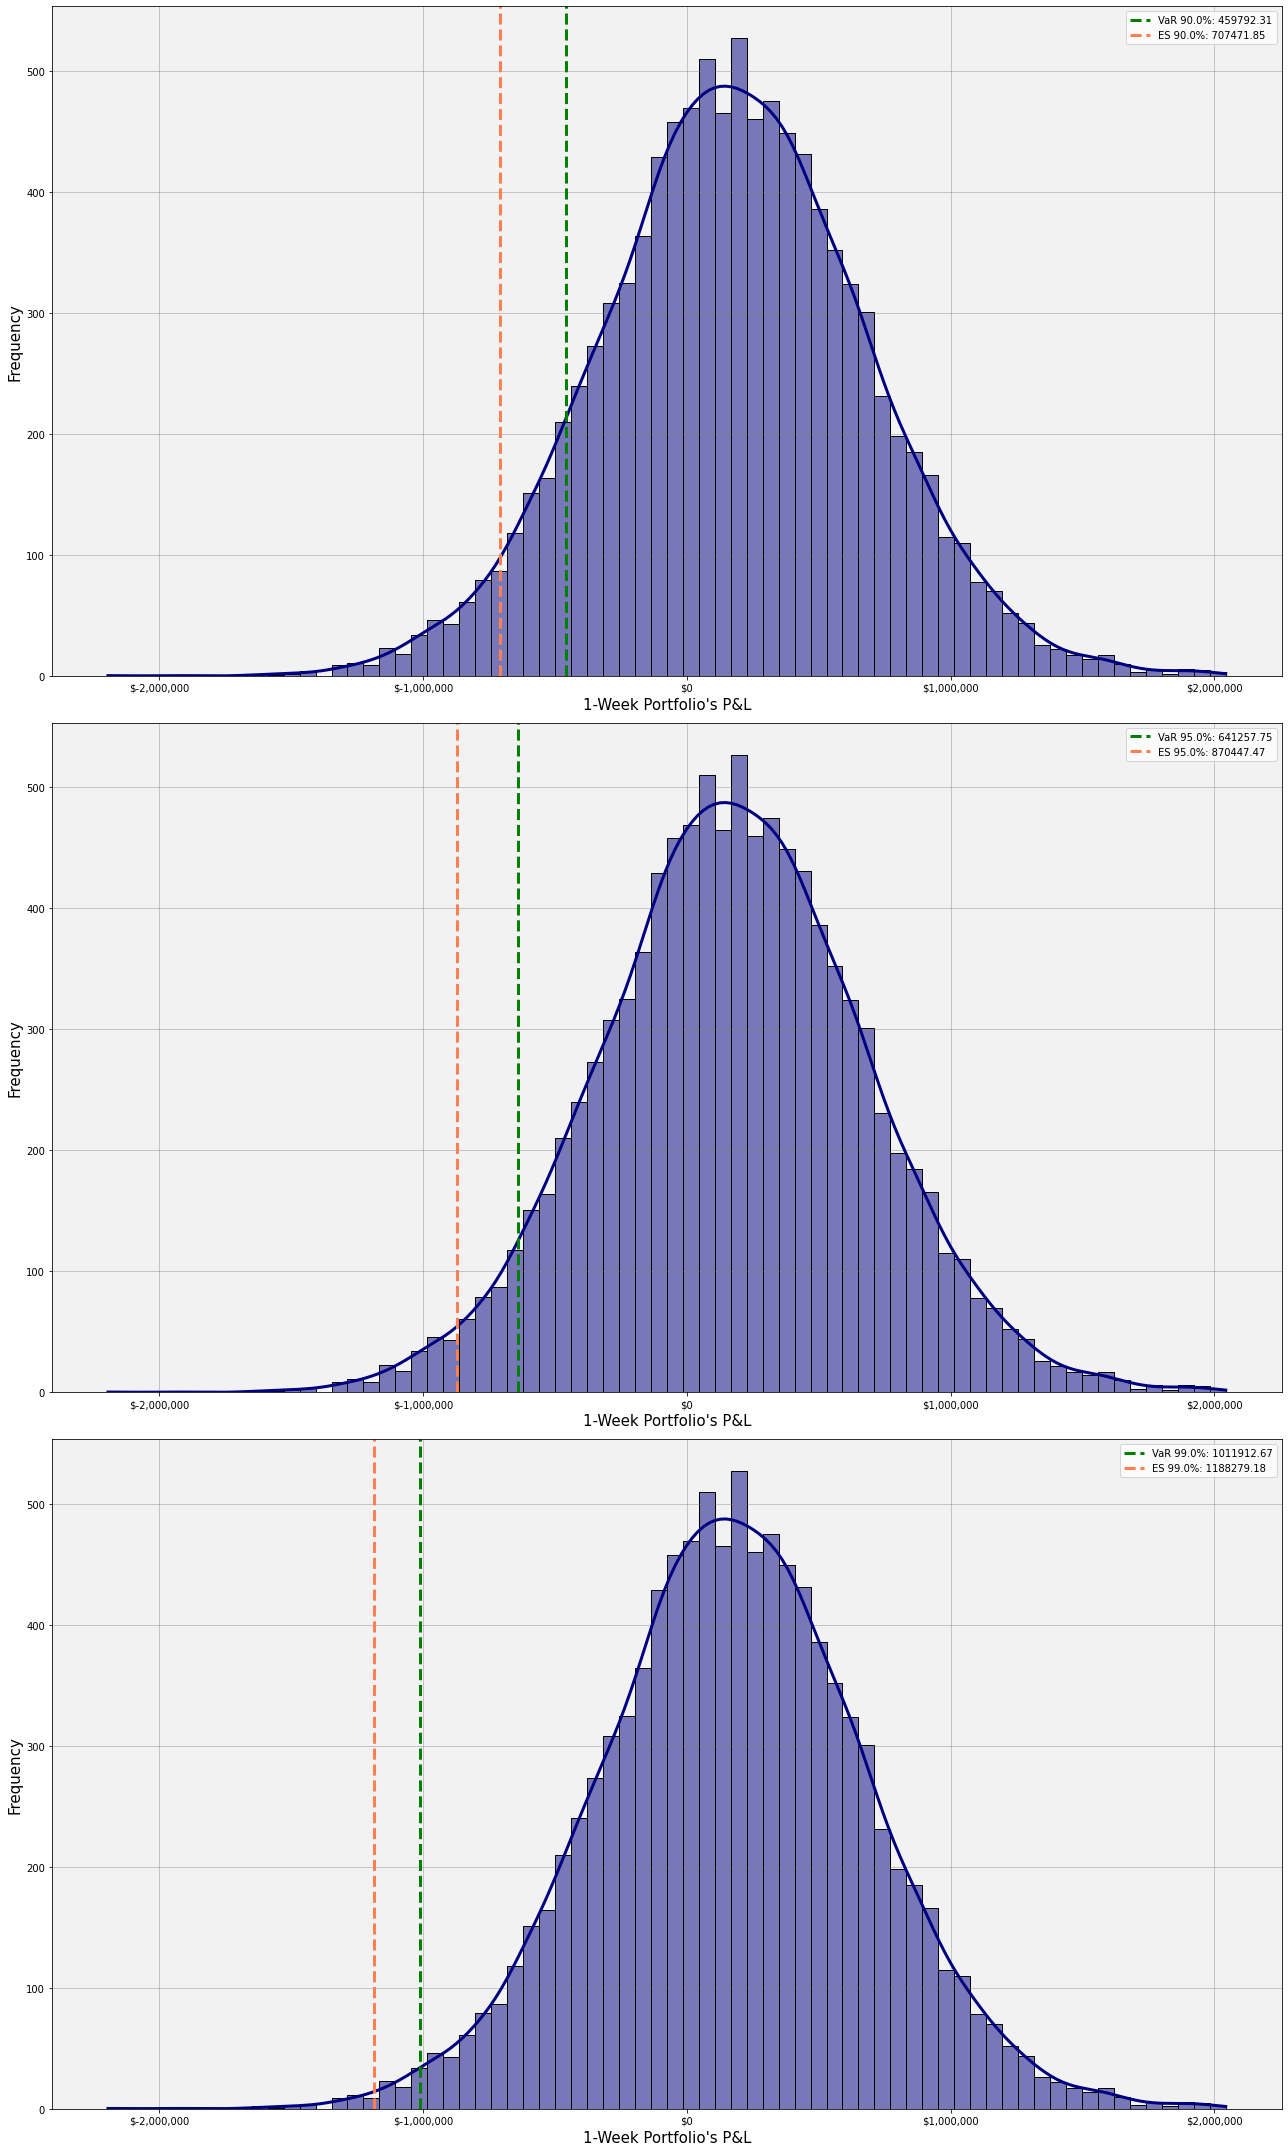

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 200 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 556974.87.
The expected shortfall for the confidence level 90.0% is 803519.38.

The value-at-risk for the confidence level 95.0% is 743486.57.
The expected shortfall for the confidence level 95.0% is 963579.98.

The value-at-risk for the confidence level 99.0% is 1098387.3.
The expected shortfall for the confidence level 99.0% is 1270282.57.



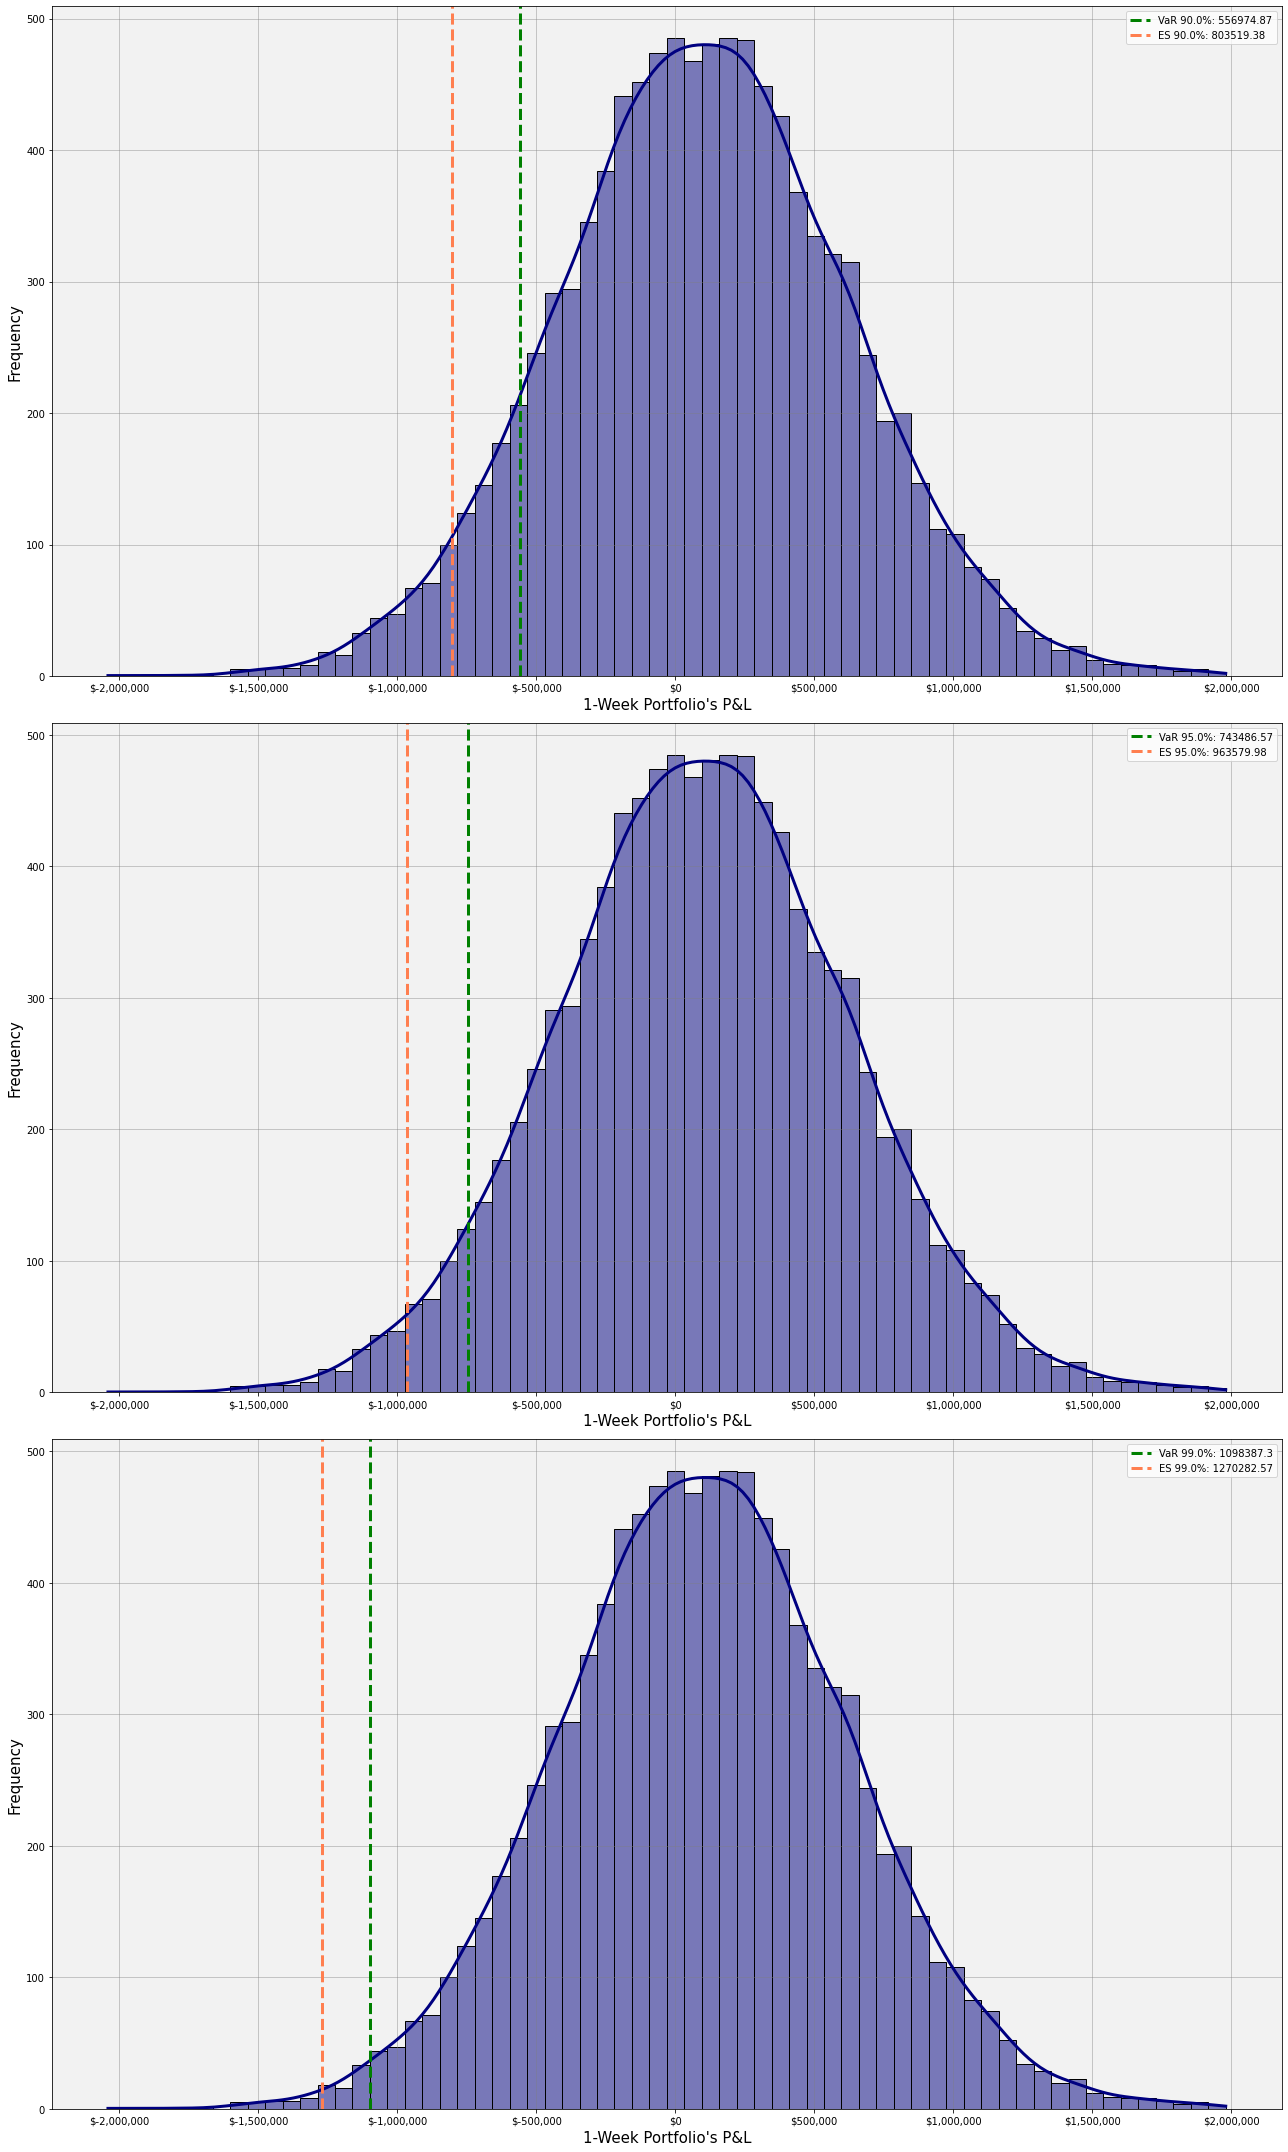

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 300 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 581502.3.
The expected shortfall for the confidence level 90.0% is 837586.98.

The value-at-risk for the confidence level 95.0% is 779254.26.
The expected shortfall for the confidence level 95.0% is 1000496.78.

The value-at-risk for the confidence level 99.0% is 1123548.64.
The expected shortfall for the confidence level 99.0% is 1321713.84.



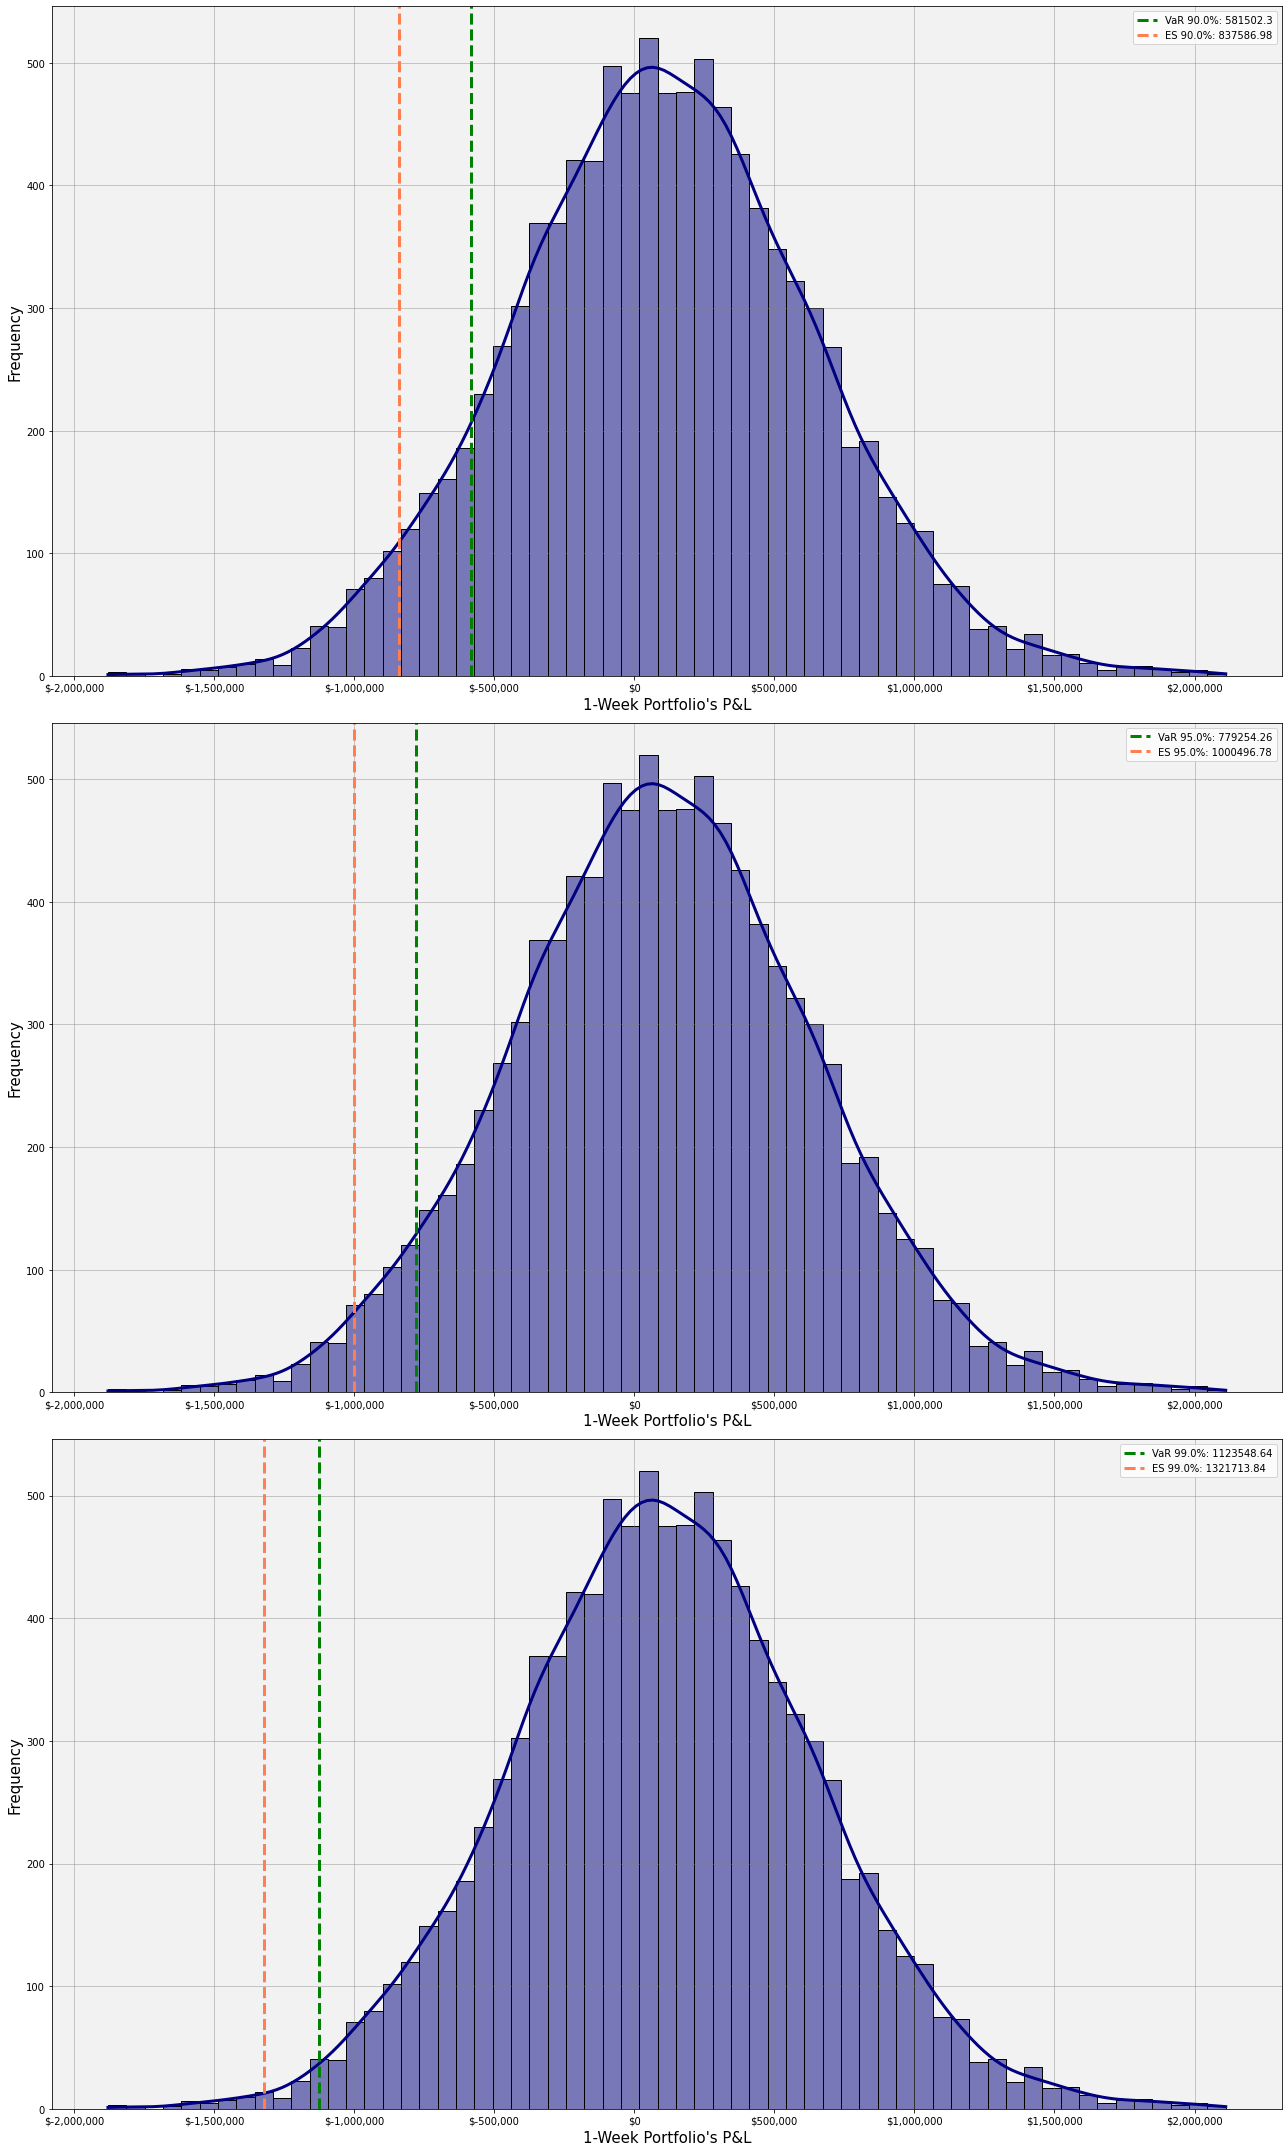

--------------------------------------------------------------------------------
SIMULATION FOR THE LAST 400 OBSERVATIONS
The value-at-risk for the confidence level 90.0% is 580285.1.
The expected shortfall for the confidence level 90.0% is 840109.32.

The value-at-risk for the confidence level 95.0% is 783674.15.
The expected shortfall for the confidence level 95.0% is 1009990.85.

The value-at-risk for the confidence level 99.0% is 1137003.23.
The expected shortfall for the confidence level 99.0% is 1326100.77.



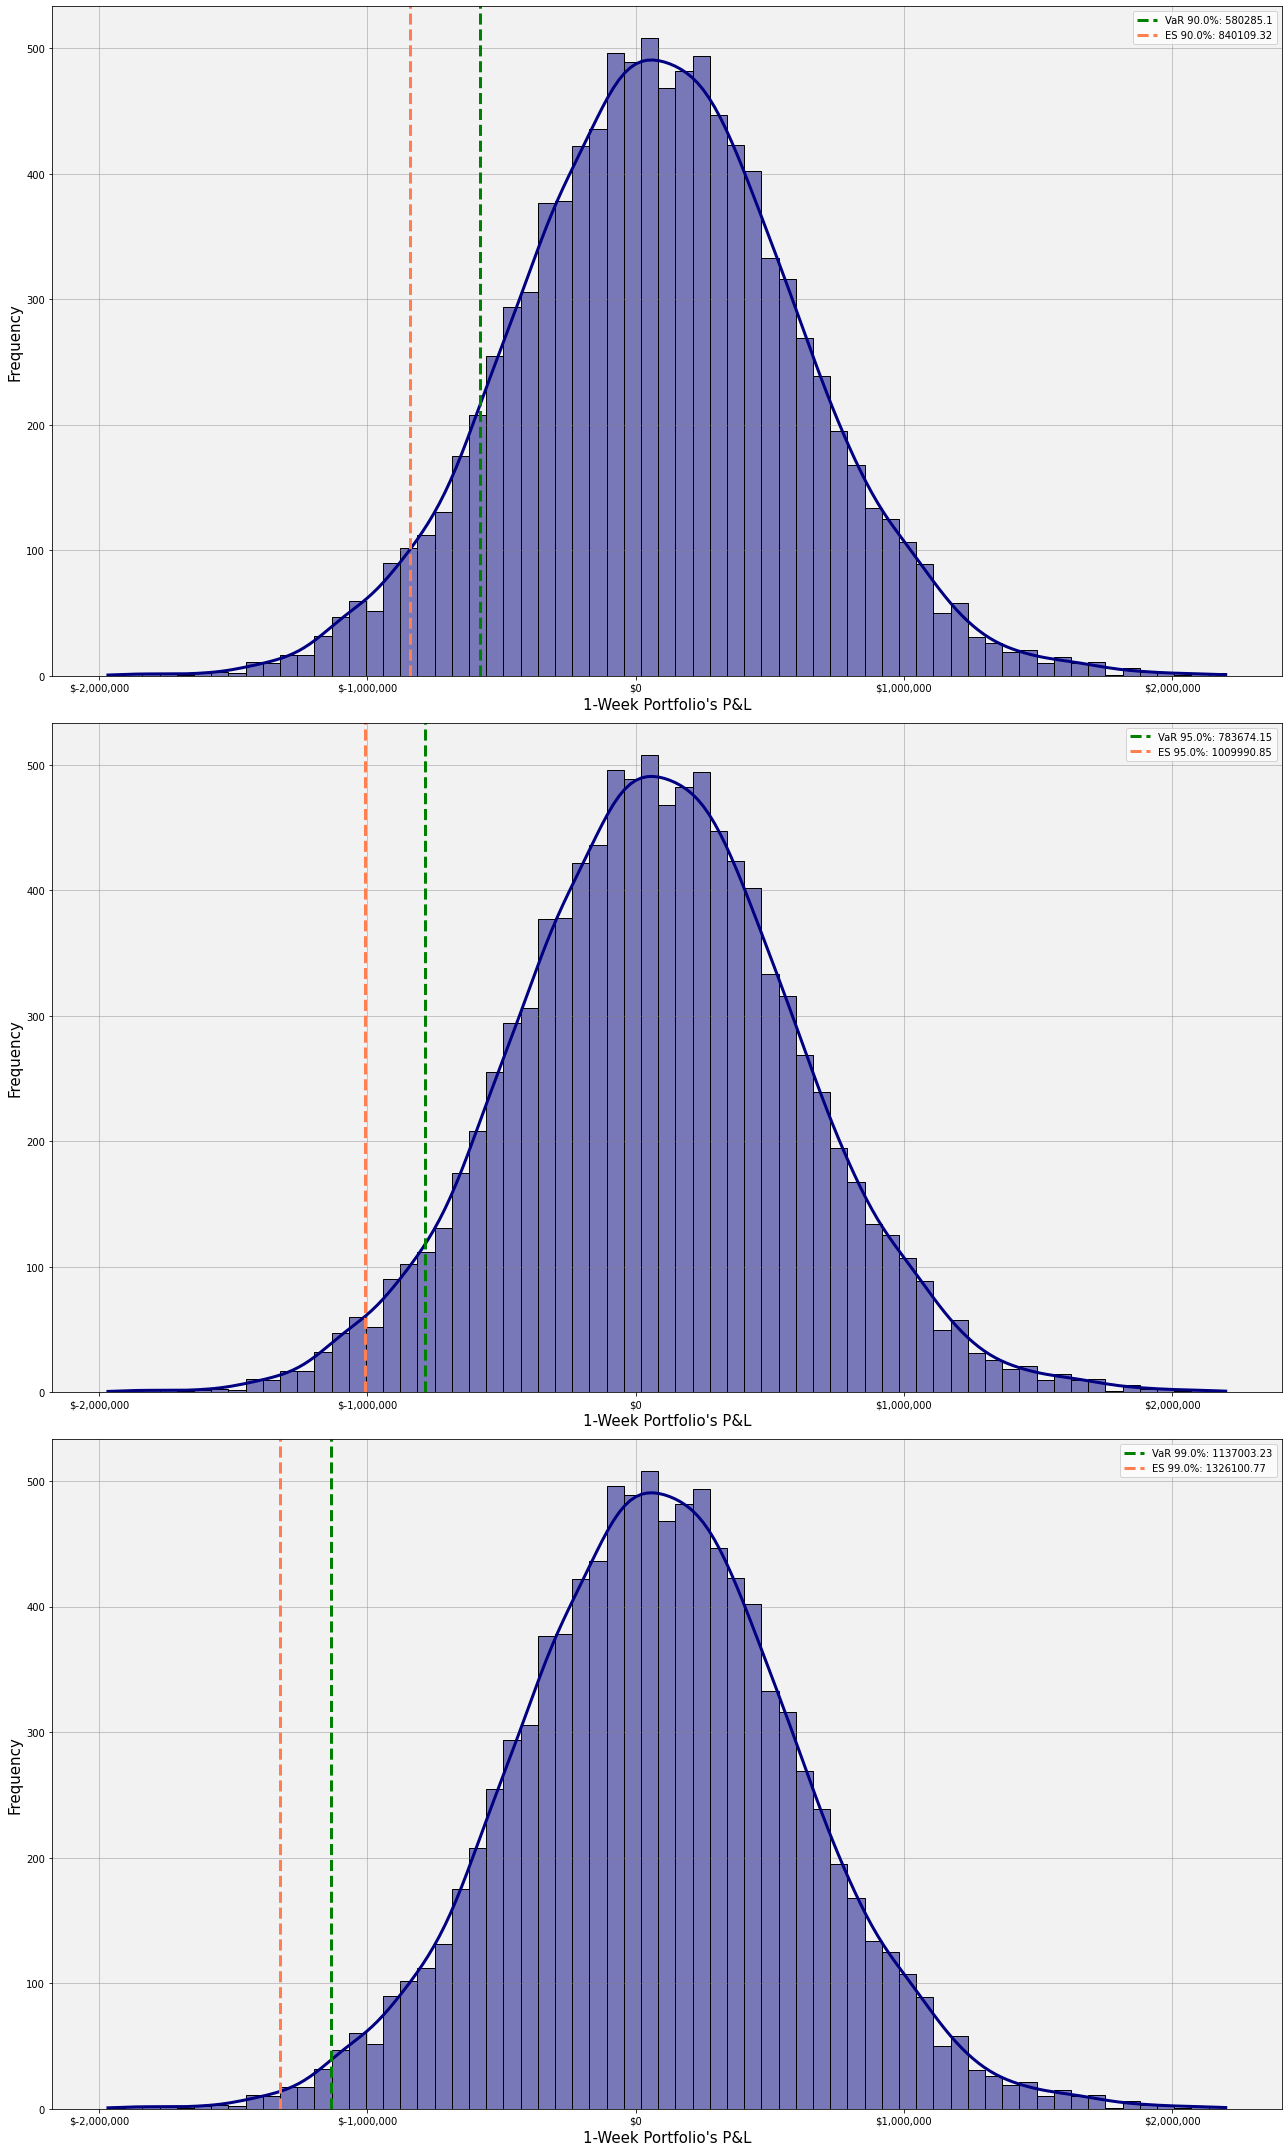

In [32]:
impact_lastobs(R1_M1, R2_M1, M4 = True)

# Exercise (v)

The methodology for this task is outlined in the paper.

In [33]:
W0 = 10000000
p_empirical_value = W0*p_return(R1_M1, R2_M1, lambda1_f = 0.3, lambda2_f = 0.7)

In [34]:
def rolling_window(R1_M1_f, R2_M1_f, p_empirical_value, conf_lvls, window = 100, M1 = False, M2 = False, M4 = False):
    """
    Computes the number of violations of the VaR level using the next out-of-sample observation
    from the original portfolio
    
    Parameters:
    R1_M1_f: empirical returns of SREN.SW
    R2_M1_f: empirical returns of NVDA.US
    p_empirical_value: original empirical portfolio values
    window: size of the window
    conf_lvls: list of confidence levels to compute VaR
    M1: if true, simulates VaR and ES for M1
    M2: if true, simulates VaR and ES for M2
    M4: if true, simulates VaR and ES for M4
    """
    VaR_historical_f_rw = []
    violations = 0
    step = 0
    
    while step < len(R1_M1_f)-window-1:
        R1_M1_rw = R1_M1_f[step:(window + step)]
        R2_M1_rw = R2_M1_f[step:(window + step)]
        
        if M1 == True:
            p_simvalue, VaR_historical_rw, ES_historical_rw = simulation_VaR_ES(R1_M1_rw, R2_M1_rw, lambda1_f = 0.3,
                                                                                lambda2_f = 0.7, W0 = 10000000, conf_lvls = [0.95],
                                                                                M1 = True)
        
        elif M2 == True:
            p_simvalue, VaR_historical_rw, ES_historical_rw = simulation_VaR_ES(R1_M1_rw, R2_M1_rw, lambda1_f = 0.3,
                                                                                lambda2_f = 0.7, W0 = 10000000, conf_lvls = [0.95],
                                                                                M2 = True)
        
        elif M4 == True:
            p_simvalue, VaR_historical_rw, ES_historical_rw = simulation_VaR_ES(R1_M1_rw, R2_M1_rw, lambda1_f = 0.3,
                                                                                lambda2_f = 0.7, W0 = 10000000, conf_lvls = [0.95],
                                                                                M4 = True)
        
        VaR_historical_f_rw.append(VaR_historical_rw[0])
        next_obs = p_empirical_value[step + window + 1] # next out of sample observation
        
        if next_obs < VaR_historical_rw[0]:
            violations += 1
        
        step += 1
        
    return VaR_historical_f_rw, violations

## M1

Here we compute the total number of violations of the VaR in M1 using the next out-of-sample portfolio return.

In [35]:
VaR_historical_roll_M1, violations_M1 = rolling_window(R1_M1, R2_M1, p_empirical_value, conf_lvls = [0.95], M1 = True)
print("The total number of violations of VaR using the next out-of-sample portfolio return for M1 is {}.".format(violations_M1))

The total number of violations of VaR using the next out-of-sample portfolio return for M1 is 40.


## M2

Here we do the same for the total number of violations of the VaR in M2:

In [36]:
VaR_historical_roll_M2, violations_M2 = rolling_window(R1_M1, R2_M1, p_empirical_value, conf_lvls = [0.95], M2 = True)
print("The total number of violations of VaR using the next out-of-sample portfolio return for M2 is {}.".format(violations_M2))

The total number of violations of VaR using the next out-of-sample portfolio return for M2 is 31.


## M4

Same logic goes for the total number of violations of the VaR in M4:

In [37]:
VaR_historical_roll_M4, violations_M4 = rolling_window(R1_M1, R2_M1, p_empirical_value, conf_lvls = [0.95], M4 = True)
print("The total number of violations of VaR using the next out-of-sample portfolio return for M4 is {}.".format(violations_M4))

The total number of violations of VaR using the next out-of-sample portfolio return for M4 is 27.


# Sources

*Comonotonicity copula.* (n.d.). Nematrian. http://www.nematrian.com/ComonotonicityCopula 

GeeksforGeeks. (2023, December 26). *How to deal with missing values in a Timeseries in Python?* GeeksforGeeks. https://www.geeksforgeeks.org/how-to-deal-with-missing-values-in-a-timeseries-in-python/

Ruppert, D., & Matteson, D. S. (2015). *Statistics and data analysis for financial engineering: with R examples.* Springer.